In [1]:
import pandas as pd
import numpy as np
import itertools as it

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import json
import urllib.request

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

%matplotlib inline

# Daily COVID-19 plots

https://d14wlfuexuxgcm.cloudfront.net/covid/rt.csv

https://covidtracking.com/api/v1/states/daily.csv

https://docs.google.com/spreadsheets/d/e/2PACX-1vS8SzaERcKJOD_EzrtCDK1dX1zkoMochlA9iHoHg_RSw3V8bkpfk1mpw4pfL5RdtSOyx_oScsUtyXyk/pub?gid=43720681&single=true&output=csv

In [2]:
all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}

all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', "60": 'as',
                 "66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}
all_names_state = {j:i for i,j in all_state_names.items()}

state_posx = {'ak': (0, 0), 'me': (0, 10),#'gu': (7, 0), 'vi': (7, 9), 'pr': (7, 8), 'mp': (7, 1),
              'vt': (1, 9), 'nh': (1, 10),'wa': (2, 0), 'id': (2, 1), 'mt': (2, 2), 'nd': (2, 3), 'mn': (2, 4),
              'il': (2, 5), 'wi': (2, 6), 'mi': (2, 7), 'ny': (2, 8), 'ri': (2, 9), 'ma': (2, 10),'or': (3, 0),
              'nv': (3, 1), 'wy': (3, 2), 'sd': (3, 3), 'ia': (3, 4), 'in': (3, 5), 'oh': (3, 6), 'pa': (3, 7),
              'nj': (3, 8), 'ct': (3, 9), 'ca': (4, 0), 'ut': (4, 1), 'co': (4, 2), 'ne': (4, 3), 'mo': (4, 4),
              'ky': (4, 5), 'wv': (4, 6), 'va': (4, 7), 'md': (4, 8), 'de': (4, 9), 'az': (5, 1), 'nm': (5, 2), 
              'ks': (5, 3), 'ar': (5, 4), 'tn': (5, 5), 'nc': (5, 6), 'sc': (5, 7), 'dc': (5, 8), 'ok': (6, 3),
              'la': (6, 4), 'ms': (6, 5), 'al': (6, 6), 'ga': (6, 7), 'hi': (6, 0), 'tx': (7, 3), 'fl': (7, 7)}

In [3]:
month_dict = {'01':'January','02':'February','03':'March','04':'April','05':'May','06':'June',
              '07':'July','08':'August','09':'September','10':'October','11':'November','12':'December'}

today = str(dt.datetime.date(dt.datetime.now()))

# make DATE_DF, a simple dataframe with dates, weekdays, and weeknums
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-01', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()
dates = DATERANGE.copy()

In [4]:
up_col = '#224c88'
down_col = 'lightseagreen'
vdown_col = 'skyblue'
low_col = 'tan'

In [5]:
date_dict = dict(zip(DATE_DF['date'].values,list(range(DATE_DF.shape[0]))))

# JHU Data

In [6]:
jhu_url = 'https://coronavirus.jhu.edu/datasets/state_timeline.json'
with urllib.request.urlopen(jhu_url) as url_i:
    data_i = json.loads(url_i.read().decode())

state_pop = pd.read_csv('https://raw.githubusercontent.com/CivilServiceUSA/us-states/master/data/states.csv')
state_pop = state_pop[['state','population']].copy()
extra_states = ['District of Columbia','United States','Puerto Rico','Virgin Islands',
                'Guam','Northern Mariana Islands']
extra_populs = [692683,330854067,3193694,106631,167294,57216]
state_pop = pd.concat([state_pop,
                       pd.DataFrame({'state':extra_states,
                             'population':extra_populs})]).reset_index().iloc[:,1:]

sdate = min([i['values']['new-confirmed-cases'][0]['dt'] for i in data_i.values()])
ldate = max([i['values']['new-confirmed-cases'][0]['dt'] for i in data_i.values()])

ll_out = []
for st in data_i.keys():
    st_df_cases = pd.DataFrame(data_i[st]['values']['new-confirmed-cases'])
    st_df_cases.columns = ['date','new_cases_7day_avg','new_cases','cases']
    st_df_deaths = pd.DataFrame(data_i[st]['values']['new-deaths'])
    st_df_deaths.columns = ['date','new_deaths_7day_avg','new_deaths','deaths']
    st_df = st_df_cases.merge(st_df_deaths, how='left', on='date')

    ev_out = []
    for i in [i for i in data_i[st]['events']]:
        for ix in i['values']:
            ix['date'] = i['dt']
            ev_out.append(ix)

    st_df_events = pd.DataFrame(ev_out)
    st_df_events.columns = ['event_type','event_description','date']

    st_df = st_df.merge(st_df_events, how='left', on='date')
    st_df['state'] = st
    st_df['fips'] = all_ids_state[all_names_state[st]]
    st_df['population'] = state_pop.loc[state_pop['state']==st]['population'].values[0]
    st_df['new_cases'] = st_df['new_cases_7day_avg']
    st_df['new_deaths'] = st_df['new_deaths_7day_avg']
    st_df['new_cases_per_1000'] = st_df['new_cases'] / st_df['population'] * 1000
    st_df['new_deaths_per_1000'] = st_df['new_deaths'] / st_df['population'] * 1000
    st_df['cases_per_1000'] = st_df['cases'] / st_df['population'] * 1000
    st_df['deaths_per_1000'] = st_df['deaths'] / st_df['population'] * 1000
    st_df = DATE_DF.loc[(DATE_DF['date']>=sdate)][['date']].merge(st_df, how='left', on='date')
    ll_out.append(st_df)


llx = pd.concat(ll_out)
ll = llx[['date', 'state', 'fips', 'cases', 'deaths', 'population', 'new_cases',
       'new_deaths', 'new_cases_per_1000', 'new_deaths_per_1000',
       'cases_per_1000', 'deaths_per_1000']]

gbcol = ['cases', 'deaths', 'population', 'new_cases', 'new_deaths']
st_df = ll.groupby('date').agg({i:'sum' for i in gbcol}).reset_index()
st_df['new_cases_per_1000'] = st_df['new_cases'] / st_df['population'] * 1000
st_df['new_deaths_per_1000'] = st_df['new_deaths'] / st_df['population'] * 1000
st_df['cases_per_1000'] = st_df['cases'] / st_df['population'] * 1000
st_df['deaths_per_1000'] = st_df['deaths'] / st_df['population'] * 1000
st_df['state'] = 'United States'
st_df['fips'] = '00'
ll = pd.concat([ll,st_df]).sort_values(['fips','date']).reset_index().iloc[:,1:]
ll.loc[~ll['state'].isna()].copy()
ll = ll.drop_duplicates().reset_index().iloc[:,1:]

In [7]:
states = ll.state.unique().tolist()
dates = ll.date.unique().tolist()
ld = ll.date.unique().tolist()[-1]
fd = ll.date.unique().tolist()[0]
ld = month_dict[ld[5:7]]+" "+ld[-2:]+", "+ld[:4]
fd = month_dict[fd[5:7]]+" "+fd[-2:]+", "+fd[:4]

In [8]:
url_st_hosp = 'https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD'
hosp_st = pd.read_csv(url_st_hosp)
hosp_st['date'] = pd.to_datetime(hosp_st['date']).astype(str)
hosp_st = hosp_st.loc[hosp_st['date']>'2020-07-15'].copy()
hosp_st = hosp_st.sort_values(['state','date']).reset_index().iloc[:,1:]
hosp_st['state'] = [all_state_names[st.lower()] for st in hosp_st['state']]

all_prev_cols = ['previous_day_admission_adult_covid_confirmed',
                 'previous_day_admission_adult_covid_suspected',
                 'previous_day_admission_pediatric_covid_confirmed',
                 'previous_day_admission_pediatric_covid_suspected']
adult_prev_cols = ['previous_day_admission_adult_covid_confirmed',
                   'previous_day_admission_adult_covid_suspected']
child_prev_cols = ['previous_day_admission_pediatric_covid_confirmed',
                   'previous_day_admission_pediatric_covid_suspected']
adult_total_cols = 'total_adult_patients_hospitalized_confirmed_and_suspected_covid'
child_total_cols = 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid'
total_cols = ['total_adult_patients_hospitalized_confirmed_and_suspected_covid',
              'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid']

hosp_st['previous_day_admission_confirmed_and_suspected'] = hosp_st[all_prev_cols].sum(axis=1)
hosp_st['total_patients_confirmed_and_suspected_covid'] = hosp_st[total_cols].sum(axis=1)
hosp_st['previous_day_pediatric_admission_confirmed_and_suspected'] = hosp_st[child_prev_cols].sum(axis=1)
hosp_st['previous_day_adult_admission_confirmed_and_suspected'] = hosp_st[adult_prev_cols].sum(axis=1)

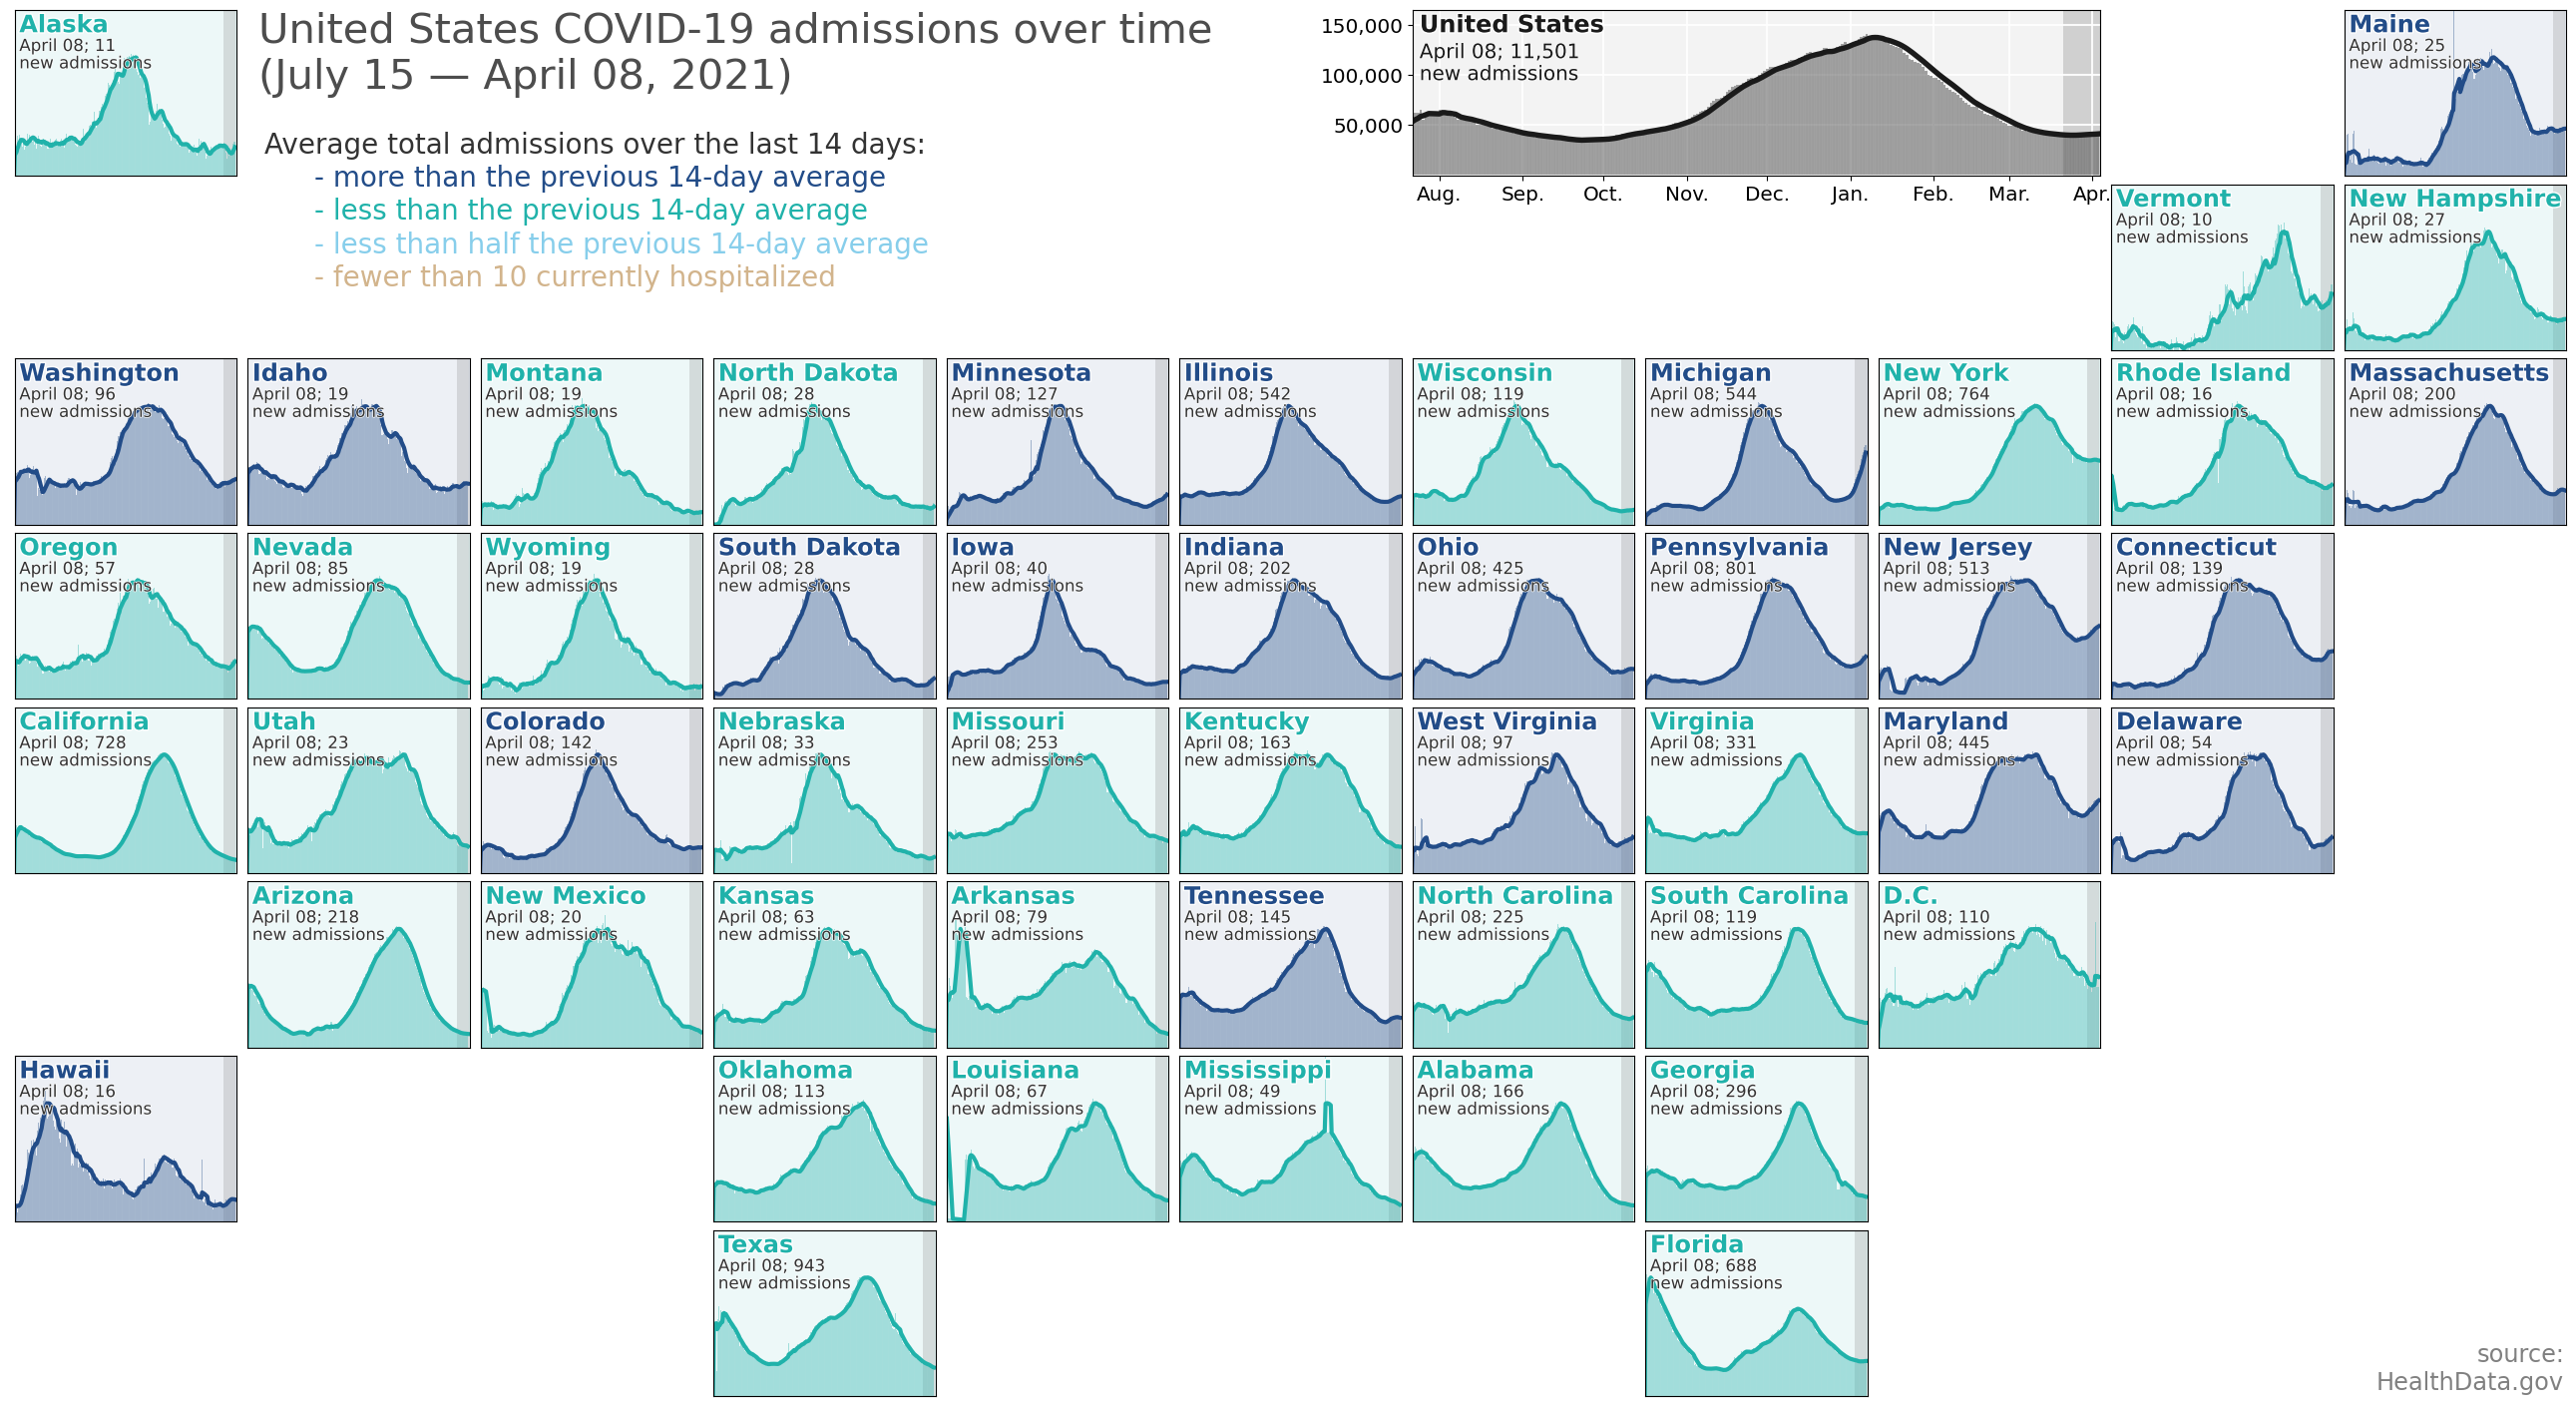

In [9]:
lw = 3
wid = 7
days_since = 14
min_c = 10

w = 3.0; h = 2.3
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

hosp_col = 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid'
hosp_col = 'total_adult_patients_hospitalized_confirmed_and_suspected_covid'
hosp_col_prev = 'previous_day_admission_confirmed_and_suspected'
hosp_col = 'total_patients_confirmed_and_suspected_covid'

for st, po in state_posx.items():
    stlab = all_state_names[st]
    ll_st = hosp_st.loc[hosp_st['state']==stlab].copy()

    xvals_st = [date_dict[i] for i in sorted(ll_st['date'].tolist())]
    yvals_st = np.nan_to_num(np.array(ll_st[hosp_col].rolling(window=wid).mean().tolist()))
    yvals_st[yvals_st<0] = 0
    yvals_st_raw = ll_st[hosp_col].tolist()
    most_recent_st = int(ll_st[hosp_col_prev].values[-1])

    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if recent_average_prev >= 2*recent_average_curr:
        col_co = vdown_col
    if recent_average_curr < min_c:
        col_co = low_col

    ax[po].plot(xvals_st, yvals_st, color=col_co, linewidth=lw)
    ax[po].bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color=col_co,fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
#     ax[po].text(0.02,0.02,'%s\ntotal'%("{:,}".format(total_cases_st)),
#                 fontsize='large',va='bottom',ha='left',
#                 color='.35',fontweight='bold',transform=ax[po].transAxes,
#                 path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
#                               path_effects.Normal()])

    casey = 0.67 if '\n' in stlab else 0.825

    ax[po].text(0.02,casey,'%s; %s\nnew admissions'%(ld[:-6], "{:,}".format(most_recent_st)),
                fontsize='large',va='top',ha='left', color='.2',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=1, foreground='w'),
                              path_effects.Normal()])

    ylim_st = ax[po].get_ylim()
    xlim_st = ax[po].get_xlim()
    ydiff = ylim_st[1]-ylim_st[0]
    ylim_st = (0-ydiff*0.001, np.nanmax(yvals_st)*1.4)
#     if np.nanmax(ll_st[hosp_col].diff()) < 110:
#         ylim_st = (-1, 150)
        
    ax[po].set_ylim(ylim_st[0], ylim_st[1])
    ax[po].set_xlim(date_dict[hosp_st['date'].min()]+6, xvals_st[-1]+2)
    ax[po].fill_between([-1,xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                        color=col_co,alpha=0.08,zorder=0)
    ax[po].fill_between([xvals_st[-days_since],xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                        color='.6',alpha=0.3,zorder=0, linewidth=0)

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()
    else:
        ax[tup].set_xticks([])
        ax[tup].set_yticks([])


stlab = 'United States'
usa_tots = hosp_st.groupby('date').agg({hosp_col:np.nansum, hosp_col_prev:np.nansum}).reset_index()
col_co = '.1'

xvals_st = [date_dict[i] for i in sorted(usa_tots['date'].tolist())]
yvals_st = usa_tots[hosp_col].rolling(window=7).mean().tolist()
yvals_st_raw = usa_tots[hosp_col].tolist()
most_recent_st = int(usa_tots[hosp_col_prev].values[-1])

gs = ax[1, 8].get_gridspec()
for a in ax[0:1, 6:9].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 6:9])

axbig.plot(xvals_st, yvals_st, color=col_co, linewidth=lw*1.3)
axbig.bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

axbig.text(0.01, 0.98, stlab, fontsize='xx-large', va='top', ha='left', color=col_co,
           fontweight='bold',transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
axbig.text(0.01, 0.8, '%s; %s\nnew admissions'%(ld[:-6], "{:,}".format(most_recent_st)), color=col_co,
           va='top',ha='left', fontsize='x-large', transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

ylim_st = axbig.get_ylim()
xlim_st = axbig.get_xlim()
ylim_st = (0, np.nanmax(yvals_st)*1.2)
ydiff = ylim_st[1] - ylim_st[0]

xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01', '2021-04-01']
xtxl = ['','Mar.','','May','','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.','Jan.','Feb.','Mar.','Apr.']
ytx = [50000, 100000, 150000]
axbig.set_xticks([date_dict[i] for i in xtx])
axbig.set_yticks(ytx)
axbig.set_xticklabels([i for i in xtxl],fontsize='x-large')
axbig.set_yticklabels(["{:,}".format(i) for i in ytx],fontsize='x-large')
axbig.grid(linewidth=1.5,color='w',alpha=0.9)

axbig.fill_between([-1, xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                   color=col_co,alpha=0.05,zorder=0)
axbig.fill_between([xvals_st[-days_since], xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                   color='.5',alpha=0.3,zorder=0, linewidth=0)

axbig.set_ylim(0-ydiff*0.005, ylim_st[1])
axbig.set_xlim(date_dict[hosp_st['date'].min()]+6, xvals_st[-1]+1)

ax[tups[-1]].text(0.99,0.01,'source:\nHealthData.gov',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.05,0.99,'United States COVID-19 admissions over time\n(July 15 — %s)'%(ld),
               color='.3', fontsize=30, va='top', ha='left', transform=ax[(0,1)].transAxes)

ax[(1,1)].text(0.075,1.15,'Average total admissions over the last %i days:'%(days_since),
                color='.2',fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.95,'- more than the previous %i-day average'%(days_since),
                color=up_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.75,'- less than the previous %i-day average'%(days_since),
                color=down_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.55,'- less than half the previous %i-day average'%(days_since),
                color=vdown_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.35,'- fewer than %i currently hospitalized'%(min_c),
                color=low_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)

plt.savefig('../figs/pngs/state_subplot_hospitalization_trends_inset.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# https://healthdata.gov/Hospital/Pediatric-Patient-Admissions-by-COVID-Status-Patie/2tcz-h6mm

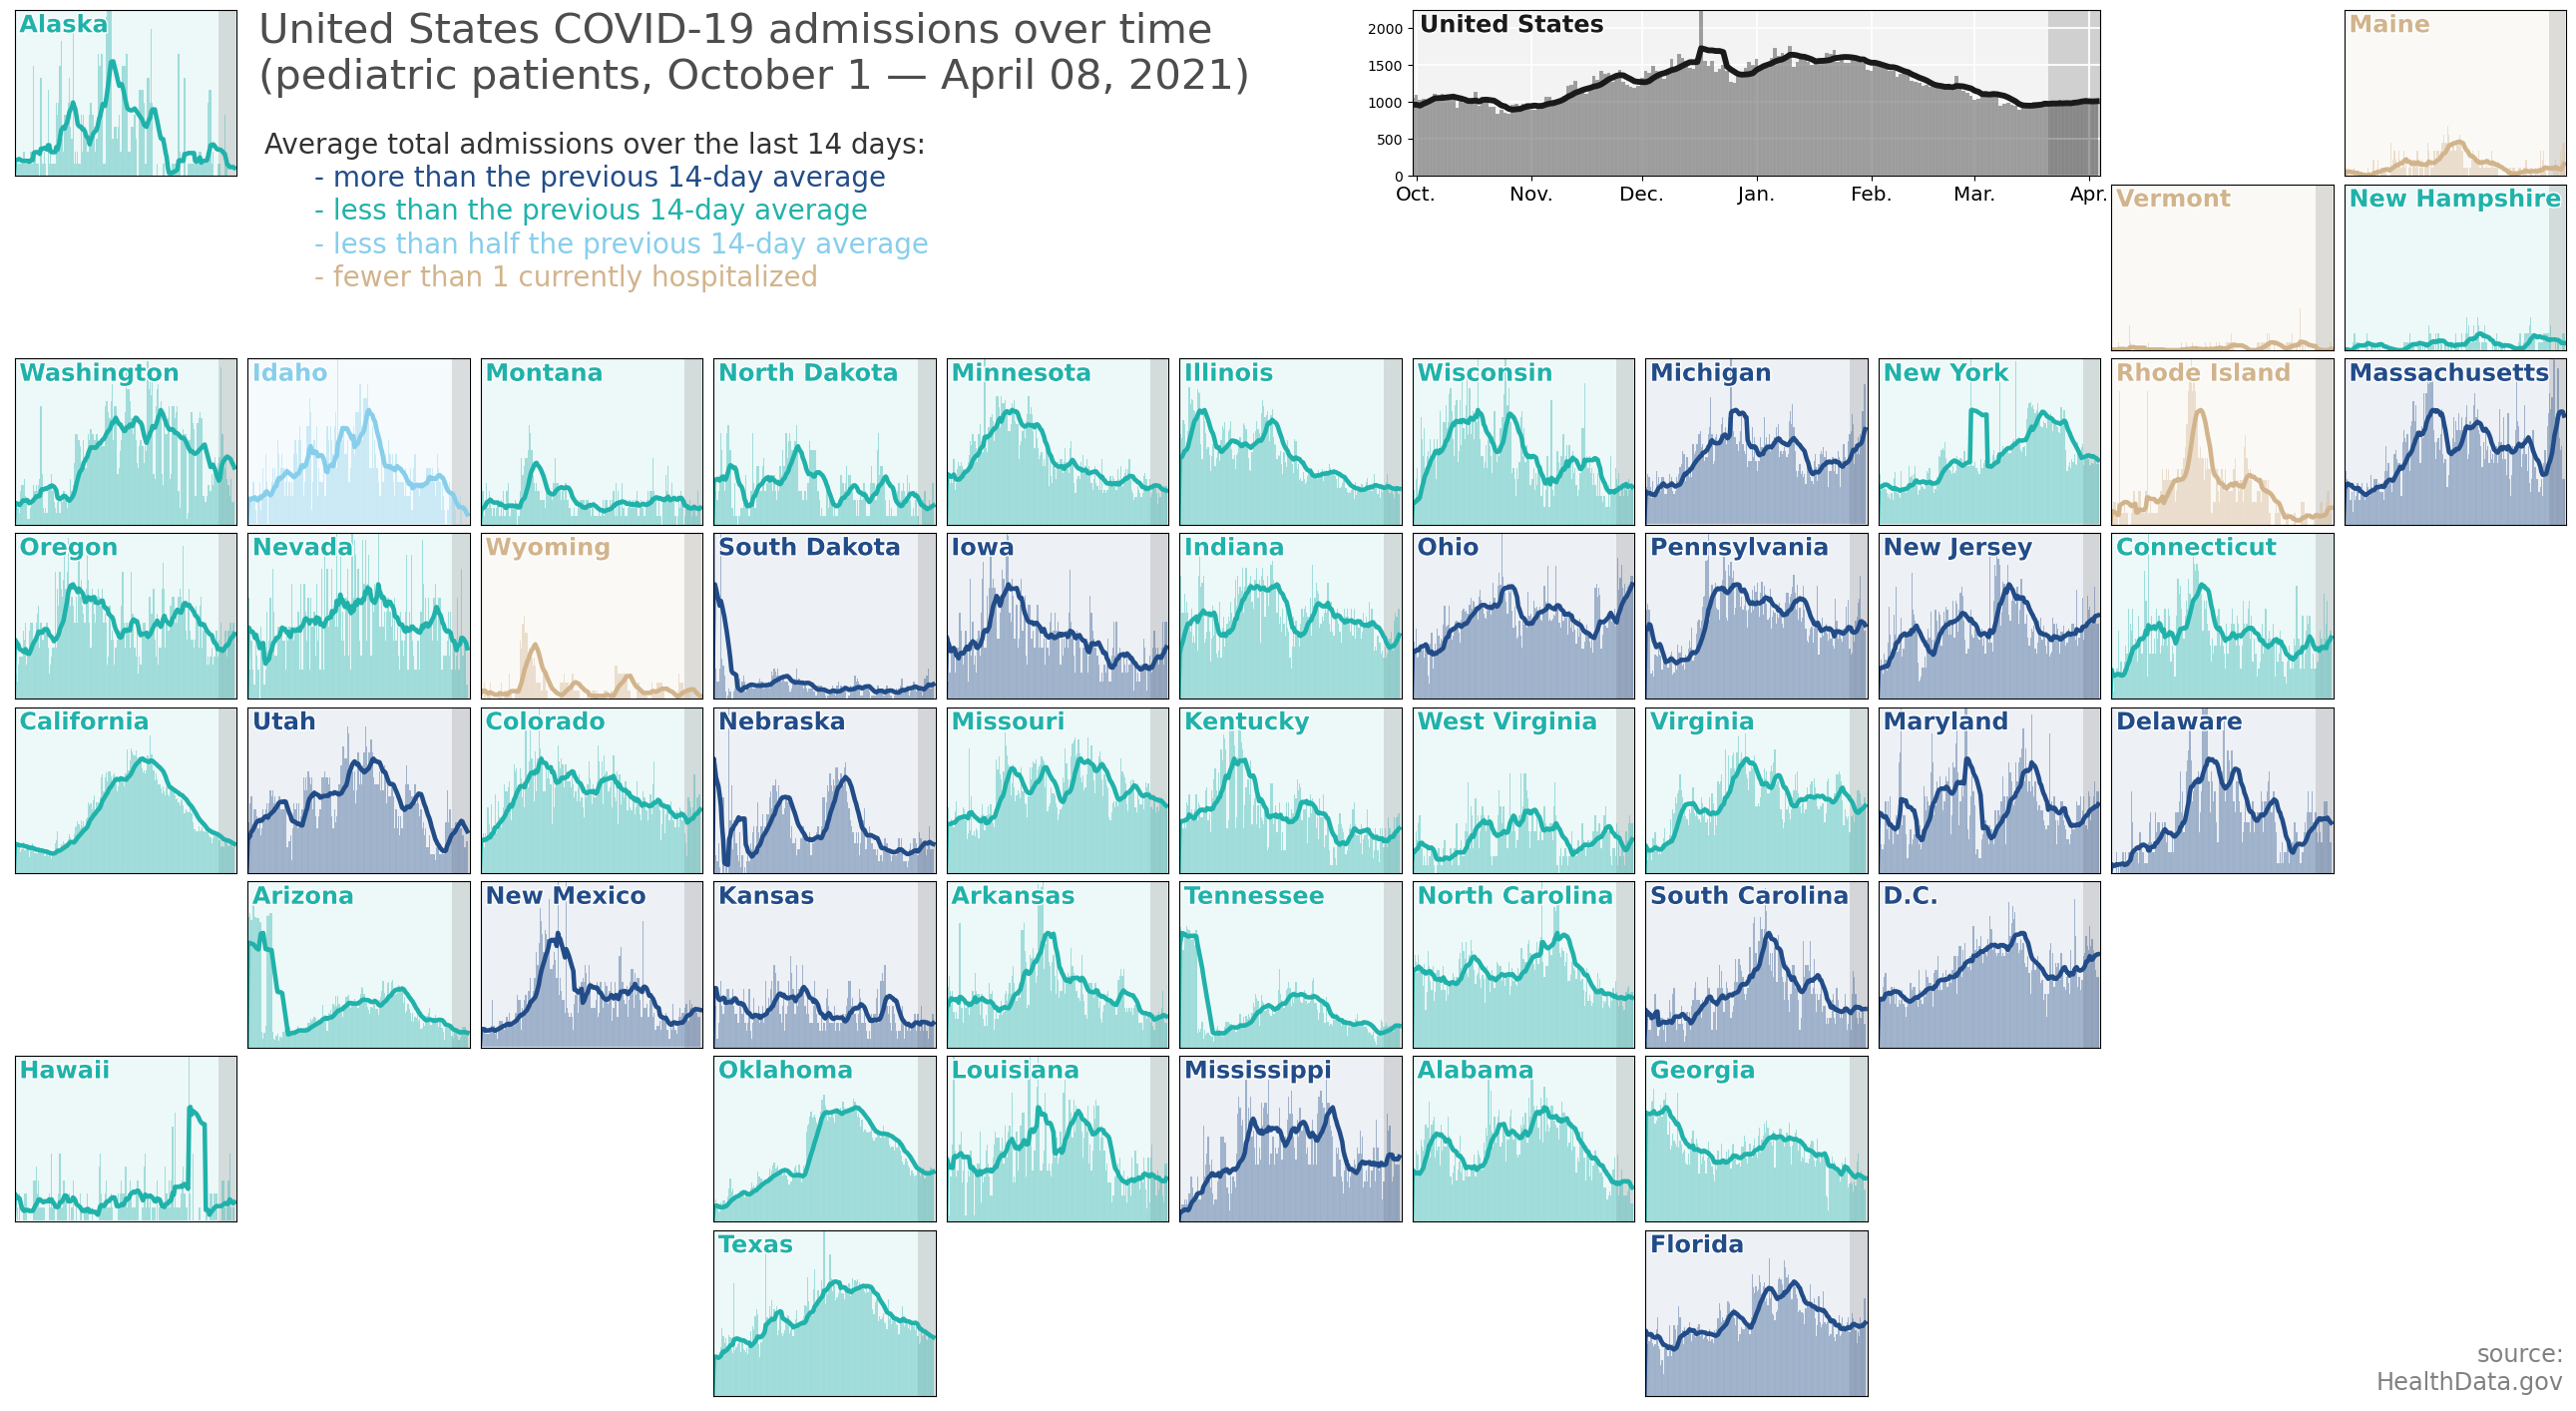

In [11]:
xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01', '2021-04-01']
xtxl = ['','Mar.','','May','','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.','Jan.','Feb.','Mar.','Apr.']

hosp_st_c = hosp_st.loc[hosp_st['date']>'2020-09-16'].copy()

lw = 3.25
wid = 14
days_since = 14
min_c = 1

w = 3.0; h = 2.3
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

hosp_col = 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid'
# hosp_col = 'total_adult_patients_hospitalized_confirmed_and_suspected_covid'
# hosp_col_prev = 'previous_day_admission_confirmed_and_suspected'
# hosp_col = 'total_patients_confirmed_and_suspected_covid'

for st, po in state_posx.items():
    stlab = all_state_names[st]
    ll_st = hosp_st_c.loc[hosp_st_c['state']==stlab].copy()

    xvals_st = [date_dict[i] for i in sorted(ll_st['date'].tolist())]
    yvals_st = np.nan_to_num(np.array(ll_st[hosp_col].rolling(window=wid).mean().tolist()))
    yvals_st[yvals_st<0] = 0
    yvals_st_raw = ll_st[hosp_col].tolist()
#     most_recent_st = int(ll_st[hosp_col_prev].values[-1])

    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if recent_average_prev >= 2*recent_average_curr:
        col_co = vdown_col
    if recent_average_curr < min_c:
        col_co = low_col

    ax[po].plot(xvals_st, yvals_st, color=col_co, linewidth=lw)
    ax[po].bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color=col_co,fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])

    casey = 0.67 if '\n' in stlab else 0.825

    ylim_st = ax[po].get_ylim()
    xlim_st = ax[po].get_xlim()
    ydiff = ylim_st[1]-ylim_st[0]
    ylim_st = (0-ydiff*0.001, np.nanmax(yvals_st)*1.45)
    if np.nanmax(ll_st[hosp_col].max()) < 15:
        ylim_st = (-0.01, 20)
        
    ax[po].set_ylim(ylim_st[0], ylim_st[1])
    ax[po].set_xlim(date_dict[hosp_st_c['date'].min()]+wid-1, xvals_st[-1]+2)
    ax[po].fill_between([-1,xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                        color=col_co,alpha=0.08,zorder=0)
    ax[po].fill_between([xvals_st[-days_since],xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                        color='.6',alpha=0.3,zorder=0, linewidth=0)

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()
    else:
        ax[tup].set_xticks([])
        ax[tup].set_yticks([])


stlab = 'United States'
usa_tots = hosp_st_c.groupby('date').agg({hosp_col:np.nansum, hosp_col_prev:np.nansum}).reset_index()
col_co = '.1'

xvals_st = [date_dict[i] for i in sorted(usa_tots['date'].tolist())]
yvals_st = usa_tots[hosp_col].rolling(window=7).mean().tolist()
yvals_st_raw = usa_tots[hosp_col].tolist()
most_recent_st = int(usa_tots[hosp_col_prev].values[-1])

gs = ax[1, 8].get_gridspec()
for a in ax[0:1, 6:9].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 6:9])

axbig.plot(xvals_st, yvals_st, color=col_co, linewidth=lw*1.3)
axbig.bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

axbig.text(0.01, 0.98, stlab, fontsize='xx-large', va='top', ha='left', color=col_co,
           fontweight='bold',transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])

ylim_st = axbig.get_ylim()
xlim_st = axbig.get_xlim()
ylim_st = (0, np.nanmax(yvals_st)*1.3)
ydiff = ylim_st[1] - ylim_st[0]

# ytx = [50000, 100000, 150000]
axbig.set_xticks([date_dict[i] for i in xtx])
# axbig.set_yticks(ytx)
axbig.set_xticklabels([i for i in xtxl],fontsize='x-large')
# axbig.set_yticklabels(["{:,}".format(i) for i in ytx],fontsize='x-large')
axbig.grid(linewidth=1.5,color='w',alpha=0.9)

axbig.fill_between([-1, xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                   color=col_co,alpha=0.05,zorder=0)
axbig.fill_between([xvals_st[-days_since], xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                   color='.5',alpha=0.3,zorder=0, linewidth=0)

axbig.set_ylim(0-ydiff*0.005, ylim_st[1])
axbig.set_ylim(ylim_st[0], ylim_st[1])
axbig.set_xlim(date_dict[hosp_st_c['date'].min()]+wid-1, xvals_st[-1]+1)

ax[tups[-1]].text(0.99,0.01,'source:\nHealthData.gov',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.05,0.99,'United States COVID-19 admissions over time\n'+\
               '(pediatric patients, October 1 — %s)'%(ld),
               color='.3', fontsize=30, va='top', ha='left', transform=ax[(0,1)].transAxes)

ax[(1,1)].text(0.075,1.15,'Average total admissions over the last %i days:'%(days_since),
                color='.2',fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.95,'- more than the previous %i-day average'%(days_since),
                color=up_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.75,'- less than the previous %i-day average'%(days_since),
                color=down_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.55,'- less than half the previous %i-day average'%(days_since),
                color=vdown_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.35,'- fewer than %i currently hospitalized'%(min_c),
                color=low_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)

plt.savefig('../figs/pngs/state_subplot_pediatric_hosp_inset.png', dpi=300, bbox_inches='tight')
plt.show()

# Grid cartogram of new cases

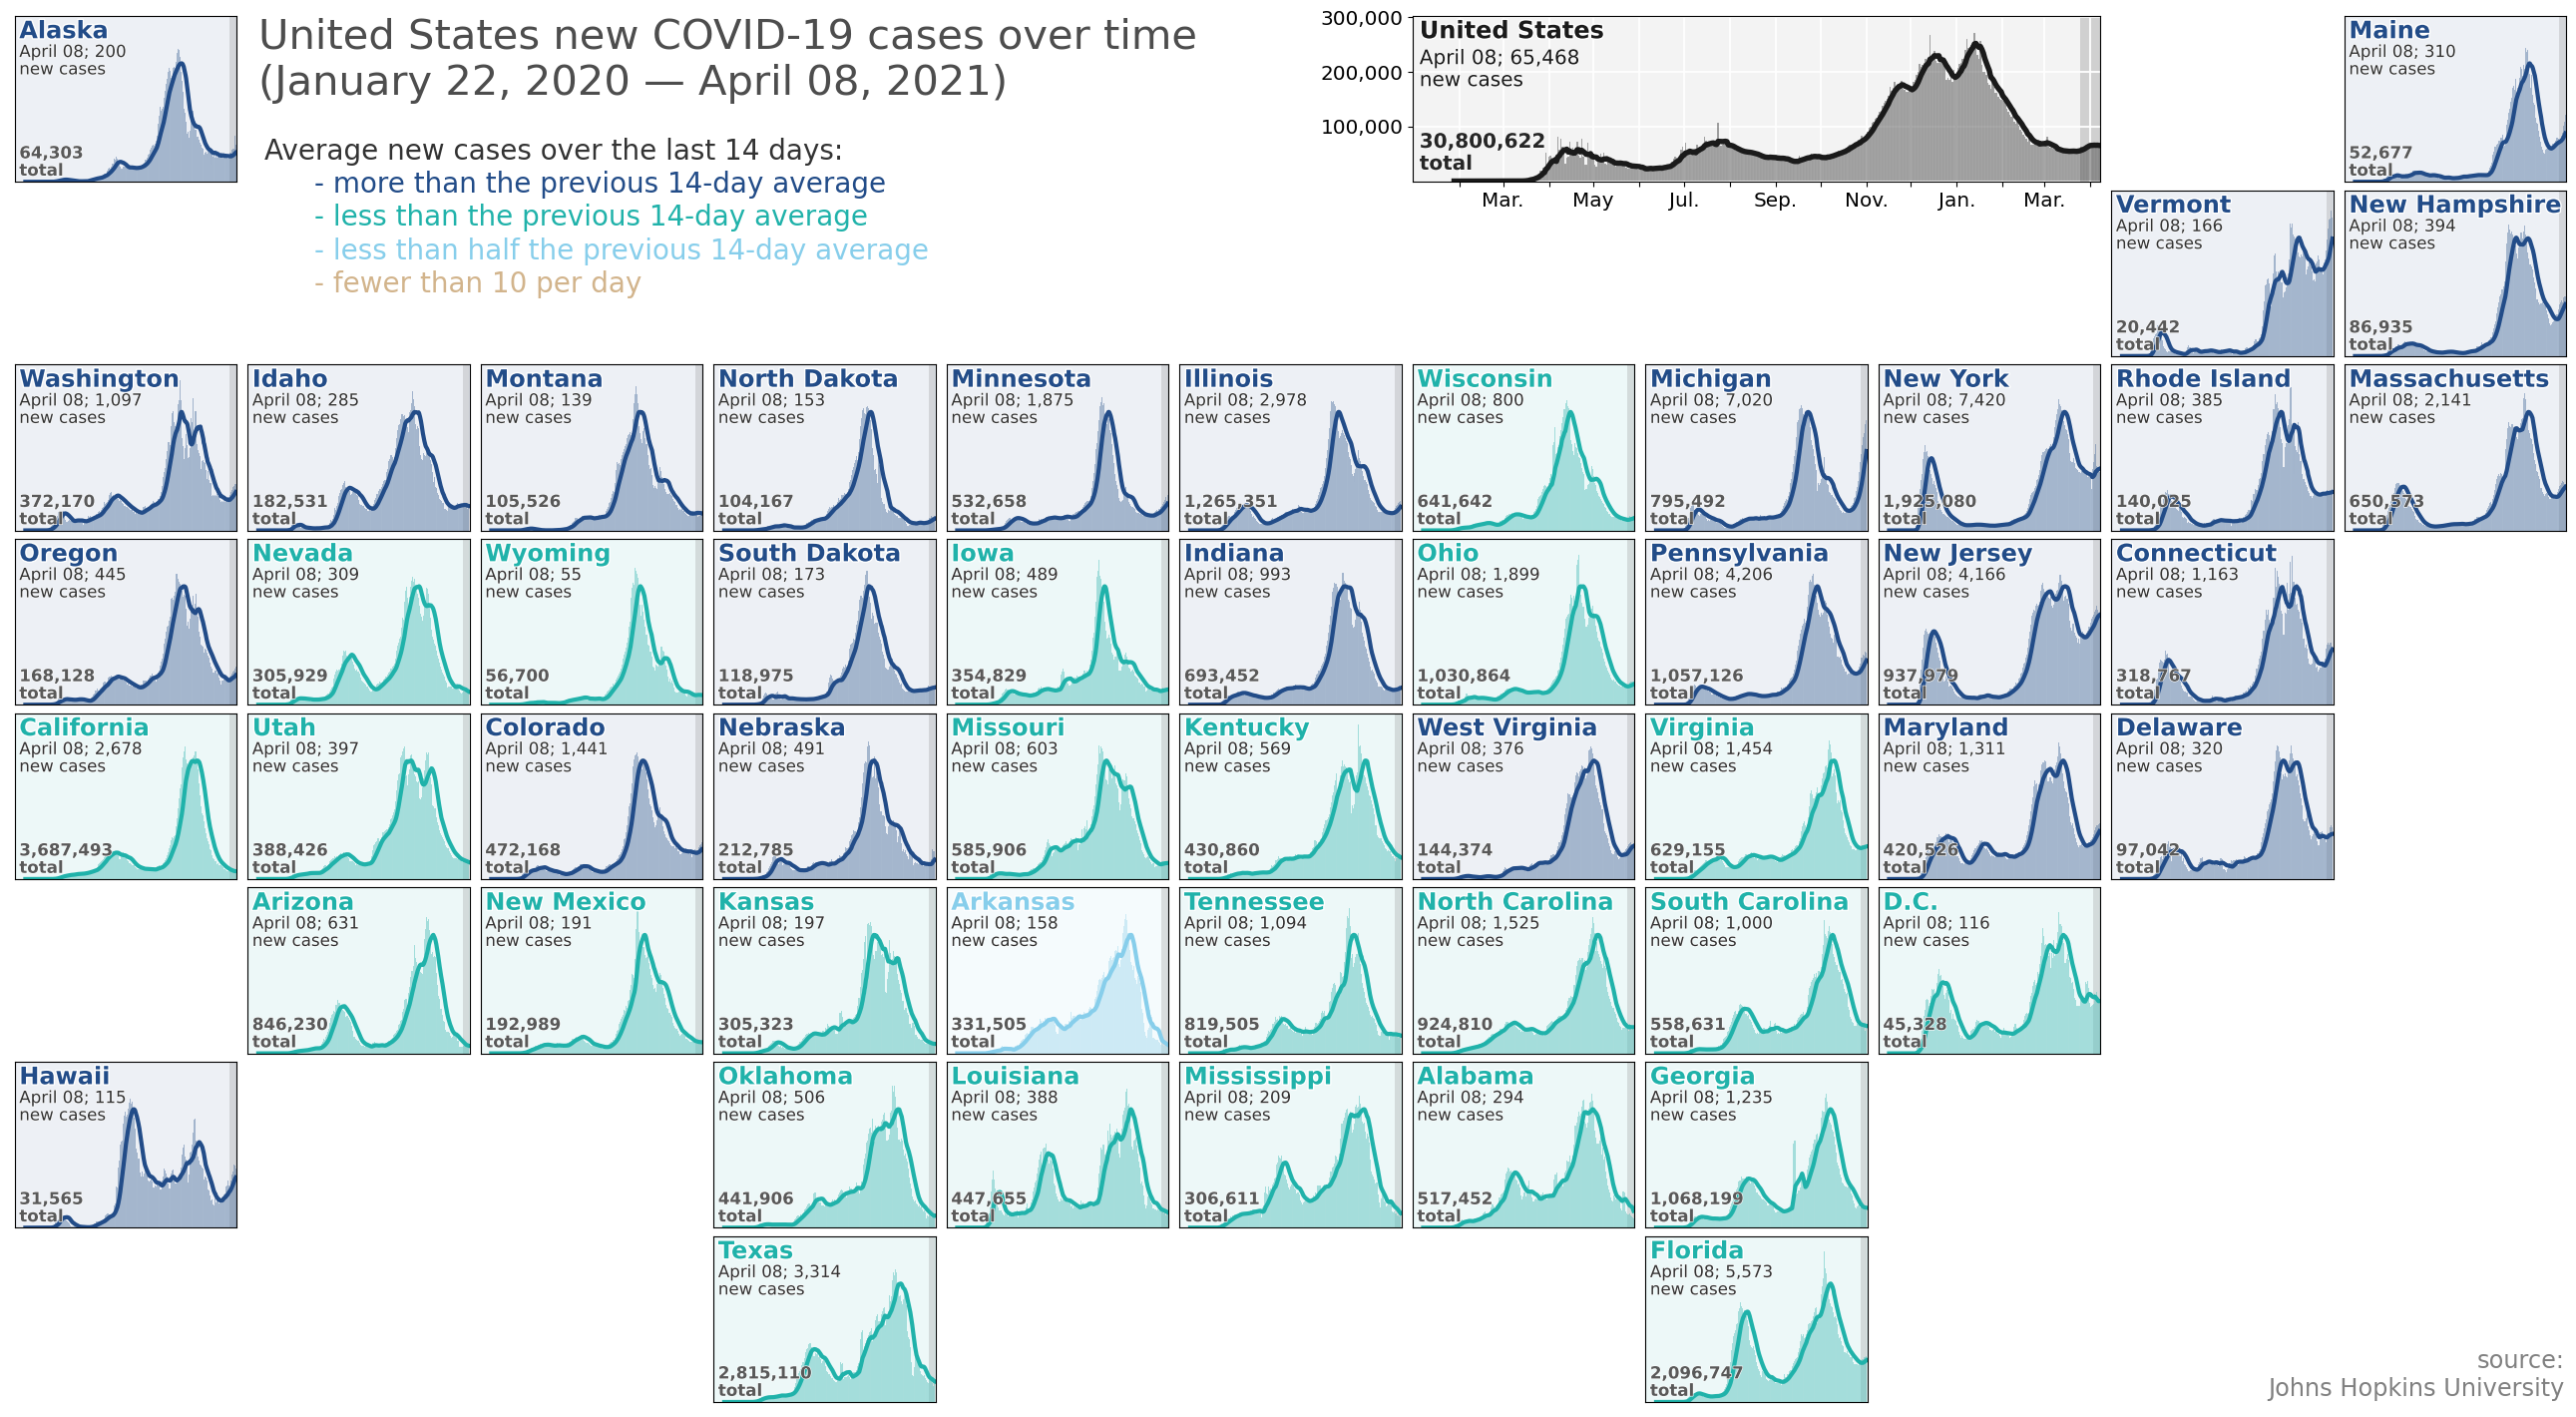

In [12]:
lw = 3
wid = 21
days_since = 14
min_c = 10

w = 3.0; h = 2.3
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for st, po in state_posx.items():
    stlab = all_state_names[st]
    ll_st = ll.loc[ll['state']==stlab].copy()
    if ll_st['cases'].values[-1] == 0:
        ll_st = ll_st.loc[ll_st['date']<today].copy()

    xvals_st = [date_dict[i] for i in sorted(ll_st['date'].tolist())]
    yvals_st = np.nan_to_num(np.array(ll_st['new_cases'].rolling(window=wid).mean().tolist()))
    yvals_st[yvals_st<0] = 0
    yvals_st_raw = ll_st['new_cases'].tolist()
    total_cases_st = int(ll_st['cases'].values[-1])
    most_recent_cases_st = int(ll_st['new_cases'].values[-1])

    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if recent_average_prev >= 2*recent_average_curr:
        col_co = vdown_col
    if recent_average_curr < min_c:
        col_co = low_col

    ax[po].plot(xvals_st, yvals_st, color=col_co, linewidth=lw)
    ax[po].bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color=col_co,fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
    ax[po].text(0.02,0.02,'%s\ntotal'%("{:,}".format(total_cases_st)),
                fontsize='large',va='bottom',ha='left',
                color='.35',fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

    casey = 0.67 if '\n' in stlab else 0.825

    ax[po].text(0.02,casey,'%s; %s\nnew cases'%(ld[:-6], "{:,}".format(most_recent_cases_st)),
                fontsize='large',va='top',ha='left', color='.2',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

    ylim_st = ax[po].get_ylim()
    xlim_st = ax[po].get_xlim()
    ydiff = ylim_st[1]-ylim_st[0]
    ylim_st = (0-ydiff*0.001, np.nanmax(yvals_st)*1.4)
    if np.nanmax(ll_st['cases'].diff()) < 110:
        ylim_st = (-1, 150)
        
    ax[po].set_ylim(ylim_st[0], ylim_st[1])
    ax[po].set_xlim(-1,xvals_st[-1]+2)
    ax[po].fill_between([-1,xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                        color=col_co,alpha=0.08,zorder=0)
    ax[po].fill_between([xvals_st[-days_since],xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                        color='.6',alpha=0.3,zorder=0, linewidth=0)

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()
    else:
        ax[tup].set_xticks([])
        ax[tup].set_yticks([])


stlab = 'United States'
usa_tots = ll.loc[ll['state']==stlab].copy()
if usa_tots['cases'].values[-1] == 0:
    usa_tots = usa_tots.loc[usa_tots['date']<today].copy()
col_co = '.1'

xvals_st = [date_dict[i] for i in sorted(usa_tots['date'].tolist())]
yvals_st = usa_tots['new_cases'].rolling(window=7).mean().tolist()
yvals_st_raw = usa_tots['new_cases'].tolist()
total_cases_st = int(usa_tots['cases'].values[-1])
most_recent_cases_st = int(usa_tots['new_cases'].values[-1])

gs = ax[1, 8].get_gridspec()
for a in ax[0:1, 6:9].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 6:9])

axbig.plot(xvals_st, yvals_st, color=col_co, linewidth=lw*1.3)
axbig.bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

axbig.text(0.01, 0.98, stlab, fontsize='xx-large', va='top', ha='left', color=col_co,
           fontweight='bold',transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
axbig.text(0.01, 0.05, '%s\ntotal'%("{:,}".format(total_cases_st)), va='bottom', ha='left', color='.15',
           fontweight='bold', fontsize='x-large', transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])
axbig.text(0.01, 0.8, '%s; %s\nnew cases'%(ld[:-6], "{:,}".format(most_recent_cases_st)), color=col_co,
           va='top',ha='left', fontsize='x-large', transform=axbig.transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

ylim_st = axbig.get_ylim()
xlim_st = axbig.get_xlim()
ylim_st = (0, np.nanmax(yvals_st)*1.2)
ydiff = ylim_st[1] - ylim_st[0]
axbig.set_ylim(0-ydiff*0.005, ylim_st[1])
axbig.set_xlim(-1, xvals_st[-1]+1)

xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','','Mar.','']
ytx = [100000, 200000, 300000]
axbig.set_xticks([date_dict[i] for i in xtx])
axbig.set_yticks(ytx)
axbig.set_xticklabels([i for i in xtxl],fontsize='x-large')
axbig.set_yticklabels(["{:,}".format(i) for i in ytx],fontsize='x-large')
axbig.grid(linewidth=1.5,color='w',alpha=0.9)

axbig.fill_between([-1, xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                   color=col_co,alpha=0.05,zorder=0)
axbig.fill_between([xvals_st[-days_since], xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                   color='.5',alpha=0.3,zorder=0, linewidth=0)

ax[tups[-1]].text(0.99,0.01,'source:\nJohns Hopkins University',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.05,0.99,'United States new COVID-19 cases over time\n(%s — %s)'%(fd,ld),
               color='.3', fontsize=30, va='top', ha='left', transform=ax[(0,1)].transAxes)

ax[(1,1)].text(0.075,1.15,'Average new cases over the last %i days:'%(days_since),
                color='.2',fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.95,'- more than the previous %i-day average'%(days_since),
                color=up_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.75,'- less than the previous %i-day average'%(days_since),
                color=down_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.55,'- less than half the previous %i-day average'%(days_since),
                color=vdown_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.35,'- fewer than %i per day'%(min_c),
                color=low_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)

plt.savefig('../figs/pngs/state_subplot_casecounts_trends_inset.png', dpi=300, bbox_inches='tight')
plt.show()

# Grid cartogram of new deaths

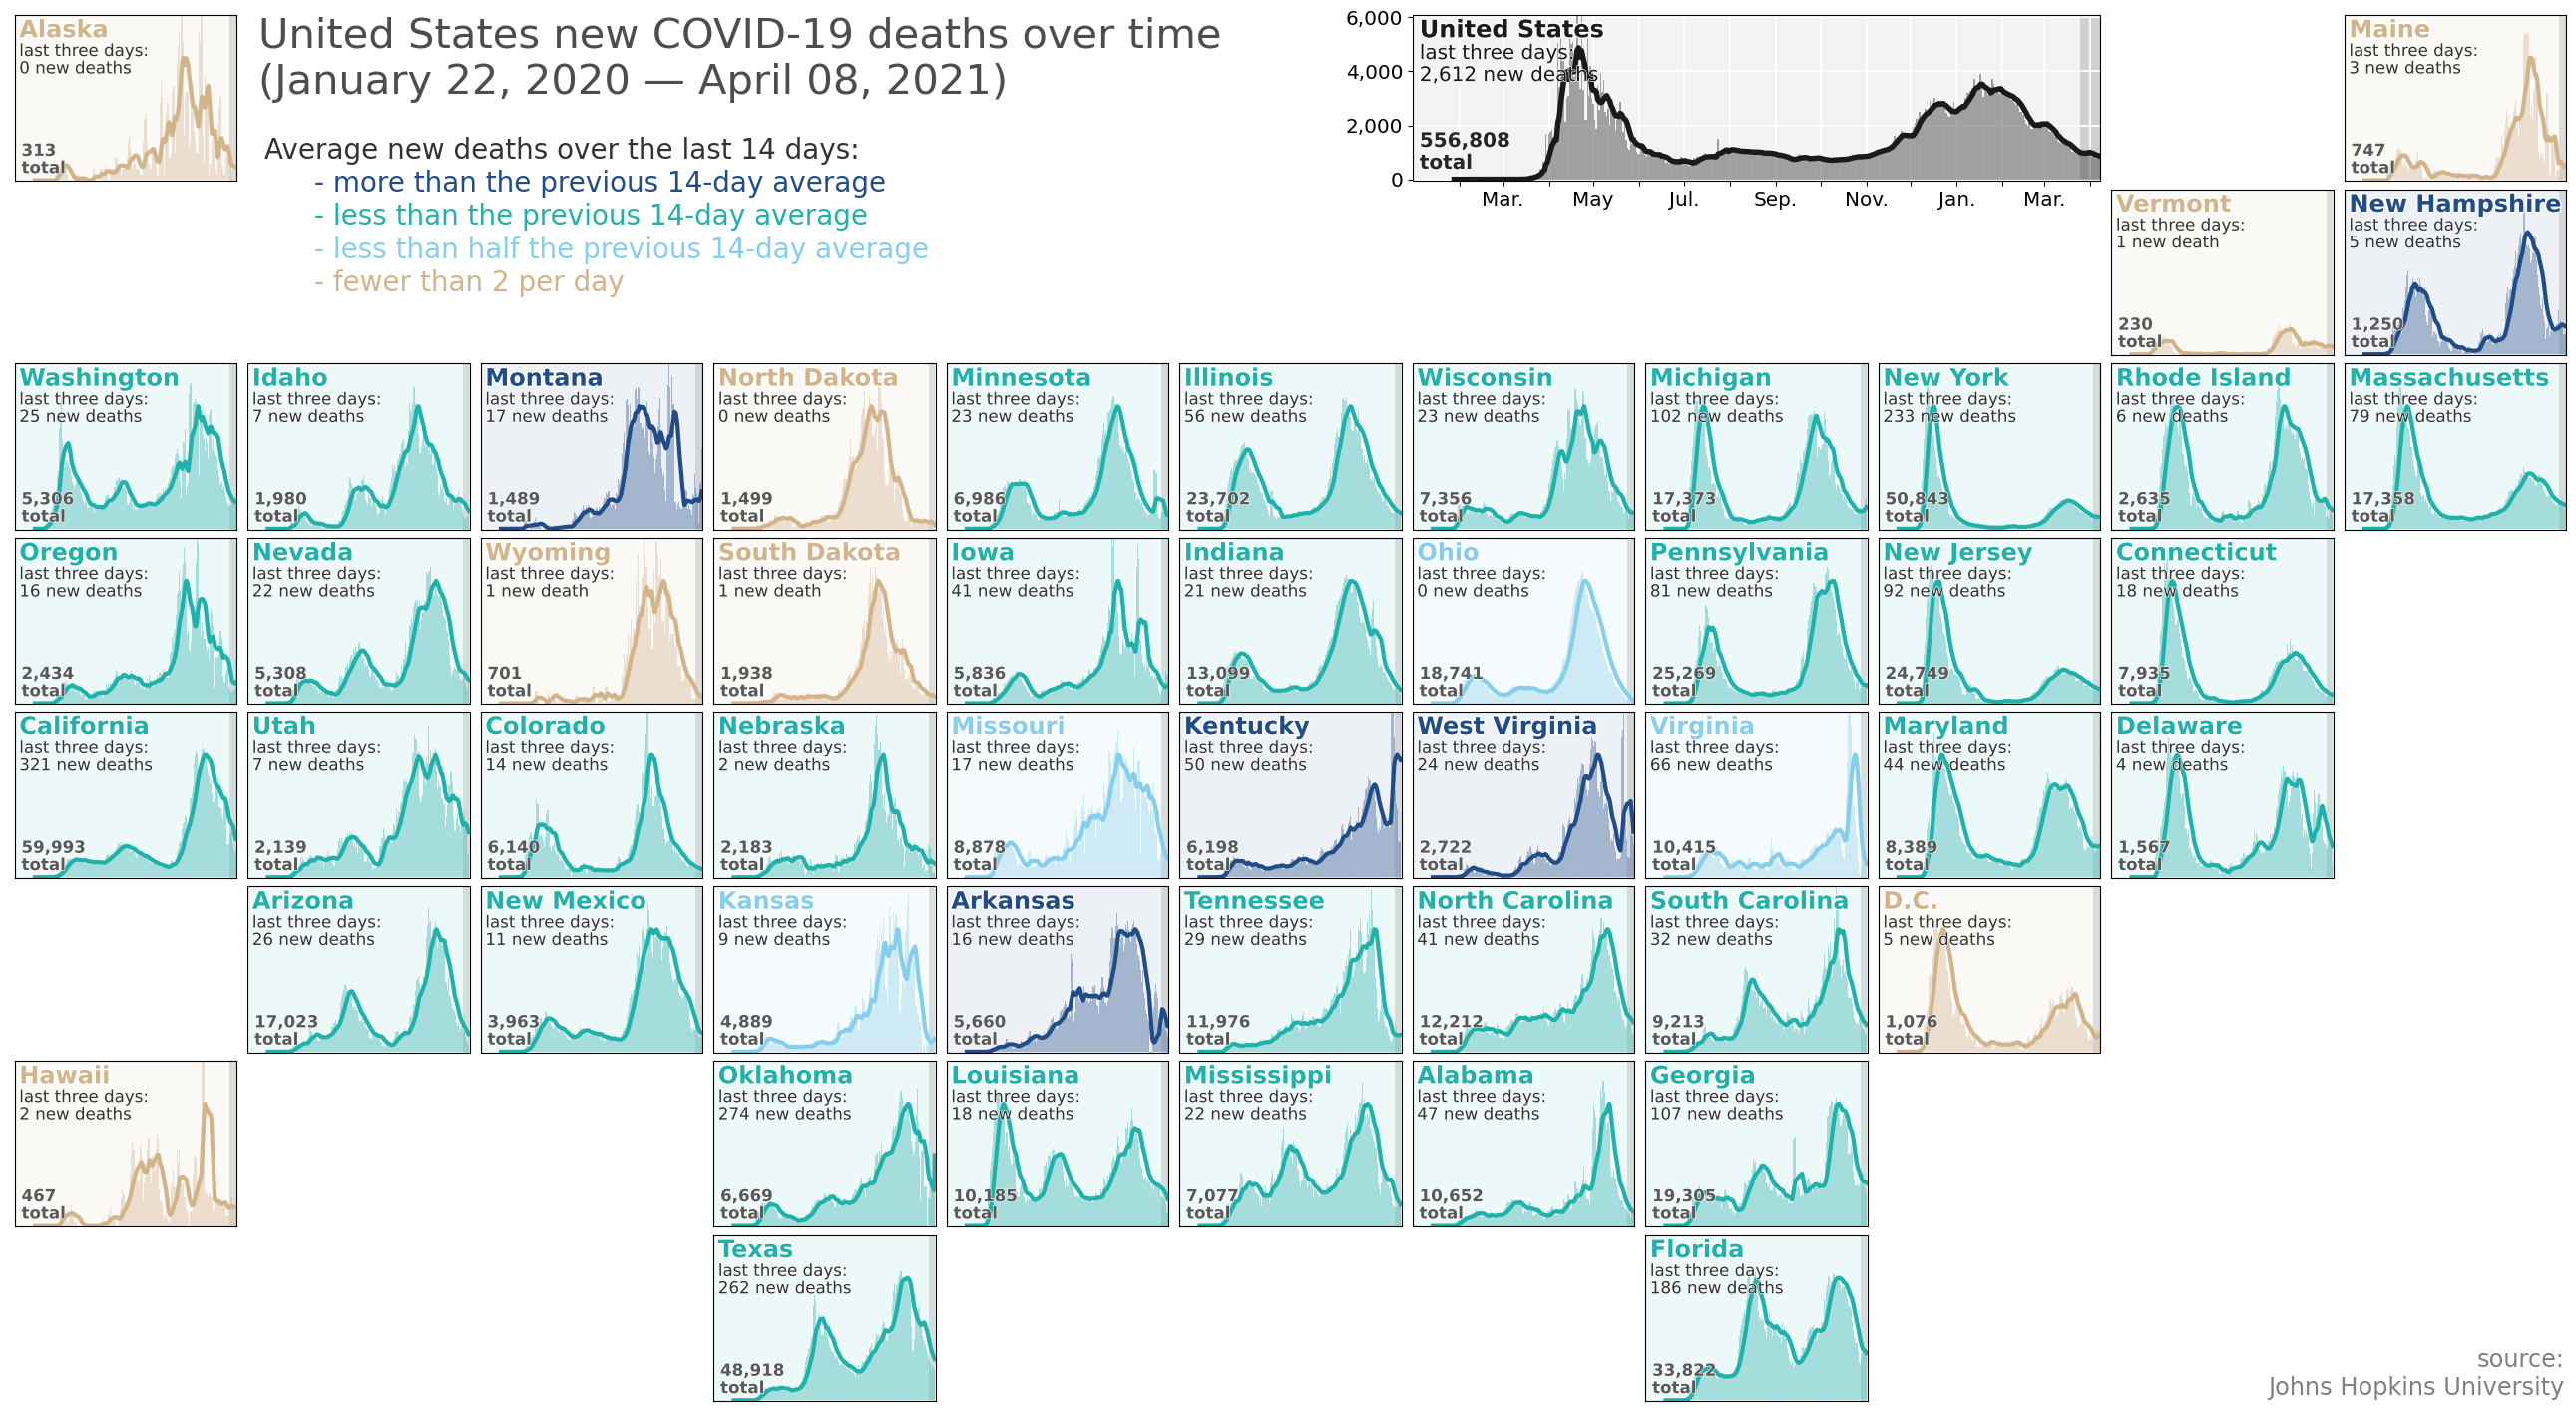

In [13]:
lw = 3
wid = 21
days_since = 14
min_c = 2

w = 3.0; h = 2.3
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for st, po in state_posx.items():
    stlab = all_state_names[st]
    ll_st = ll.loc[ll['state']==stlab].copy()
    ll_st = ll.loc[ll['state']==stlab].copy()
    if ll_st['deaths'].values[-1] == 0:
        ll_st = ll_st.loc[ll_st['date']<today].copy()

    total_deaths_st = int(ll_st['deaths'].tolist()[-1])

    xvals_st = [date_dict[i] for i in sorted(ll_st['date'].tolist())]
    yvals_st = ll_st['new_deaths'].rolling(window=wid).mean().tolist()
    yvals_st_raw = ll_st['new_deaths'].tolist()
    most_recent_deaths_st = int(ll_st['new_deaths'].values[-1])
    
    recent_average_curr = np.mean(yvals_st[(-days_since):])
    recent_average_prev = np.mean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if recent_average_prev >= 2*recent_average_curr:
        col_co = vdown_col
    if recent_average_curr < min_c:
        col_co = low_col

    ax[po].plot(xvals_st, yvals_st, color=col_co, linewidth=lw)
    ax[po].bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    ax[po].text(0.02, 0.98, stlab, fontsize='xx-large', va='top', ha='left',
                color=col_co, fontweight='bold', transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
    ax[po].text(0.03, 0.03, '%s\ntotal'%("{:,}".format(total_deaths_st)), fontsize='large',
                va='bottom', ha='left', color='.35',fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

    casey = 0.67 if '\n' in stlab else 0.825
    newd_i = int(sum(yvals_st_raw[-3:])) if sum(yvals_st_raw[-3:]) >= 0 else 0
    death_str = 'deaths' if newd_i != 1 else 'death'

    ax[po].text(0.02, casey, '%s\n%s new %s'%('last three days:', "{:,}".format(newd_i), death_str),
                fontsize='large', va='top', ha='left', color='.2', transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

    ylim_st = ax[po].get_ylim()
    xlim_st = ax[po].get_xlim()
    ylim_st = (0, np.nanmax(yvals_st)*1.35) if np.nanmax(ll_st['deaths'].diff()) >= 15 else (0, 15)
    ydiff = ylim_st[1] - ylim_st[0]

    ax[po].set_ylim(0-ydiff*0.005, ylim_st[1])
    ax[po].set_xlim(-1, xvals_st[-1]+2)
    ax[po].fill_between([-1, xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                        color=col_co, alpha=0.08, zorder=0)
    ax[po].fill_between([xvals_st[-days_since], xvals_st[-1]+1], 0-ydiff*0.02, ylim_st[1]*1.3,
                        color='.6', alpha=0.3, zorder=0, linewidth=0)

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()
    else:
        ax[tup].set_xticks([])
        ax[tup].set_yticks([])

ax[tups[-1]].text(0.99,0.01,'source:\nJohns Hopkins University',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.05,0.99,'United States new COVID-19 deaths over time\n(%s — %s)'%(fd,ld),
               color='.3', fontsize=30, va='top', ha='left', transform=ax[(0,1)].transAxes)

ax[(1,1)].text(0.075,1.15,'Average new deaths over the last %i days:'%(days_since),
                color='.2',fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.95,'- more than the previous %i-day average'%(days_since),
                color=up_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.75,'- less than the previous %i-day average'%(days_since),
                color=down_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.55,'- less than half the previous %i-day average'%(days_since),
                color=vdown_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.35,'- fewer than %i per day'%(min_c),
                color=low_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)

col_co = '.1'
stlab = 'United States'
usa_tots = ll.loc[ll['state']==stlab].copy()
if usa_tots['deaths'].values[-1] == 0:
    usa_tots = usa_tots.loc[usa_tots['date']<today].copy()

total_deaths_st = int(usa_tots['deaths'].tolist()[-1])

xvals_st = [date_dict[i] for i in sorted(usa_tots['date'].tolist())]
yvals_st = usa_tots['new_deaths'].rolling(window=7).mean().tolist()
yvals_st_raw = usa_tots['new_deaths'].tolist()
most_recent_deaths_st = int(usa_tots['new_deaths'].values[-1])

gs = ax[1, 8].get_gridspec()
for a in ax[0:1, 6:9].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 6:9])

axbig.plot(xvals_st, yvals_st, color=col_co, linewidth=lw*1.3)
axbig.bar(xvals_st, yvals_st_raw, color=col_co, alpha=0.4, width=1, linewidth=0.1, ec='w')

newd_i = int(sum(yvals_st_raw[-3:]))
death_str = 'deaths'
casey = 0.825

axbig.text(0.01, 0.98, stlab, fontsize='xx-large', va='top', ha='left', 
           color=col_co, fontweight='bold', transform=axbig.transAxes,
           path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                         path_effects.Normal()])
axbig.text(0.01, 0.05, '%s\ntotal'%("{:,}".format(total_deaths_st)), fontsize='x-large',
           va='bottom', ha='left', color='.15', fontweight='bold', transform=axbig.transAxes,
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                         path_effects.Normal()])
axbig.text(0.01, casey, '%s\n%s new %s'%('last three days:', "{:,}".format(newd_i), death_str),
           fontsize='x-large', va='top', ha='left', color=col_co, transform=axbig.transAxes,
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                         path_effects.Normal()])

ylim_st = axbig.get_ylim()
xlim_st = axbig.get_xlim()
ylim_st = (0, np.nanmax(yvals_st)*1.25)
ydiff = ylim_st[1] - ylim_st[0]

axbig.set_ylim(0-ydiff*0.01, ylim_st[1])
axbig.set_xlim(-1, xvals_st[-1]+1)

xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','','Mar.','']
ytx = [0, 2000, 4000, 6000]
axbig.set_xticks([date_dict[i] for i in xtx])
axbig.set_xticklabels([i for i in xtxl],fontsize='x-large')
axbig.set_yticks(ytx)
axbig.set_yticklabels(["{:,}".format(i) for i in ytx],fontsize='x-large')
axbig.grid(linewidth=1.5,color='w',alpha=0.9)

axbig.fill_between([-1,xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                    color=col_co,alpha=0.05,zorder=0)
axbig.fill_between([xvals_st[-days_since],xvals_st[-1]+1],0-ydiff*0.02,ylim_st[1]*1.3,
                    color='.5',alpha=0.3,zorder=0, linewidth=0)

plt.savefig('../figs/pngs/state_subplot_deathcounts_trends_inset.png', dpi=300, bbox_inches='tight')
plt.show()

__________________

# Ridge plots

In [14]:
wid = 21
ordered_states = ll.loc[~ll['state'].isna()]['state'].unique()
ordered_dict = {}
for st in ordered_states:
    if st in ['United States','Guam','Northern Mariana Islands','Virgin Islands']:
        continue
    ll_st = ll.loc[(ll['state']==st)].copy()
    temp = dict(zip(ll_st['date'],ll_st['new_cases']))
    padx = date_dict[ll_st['date'].values[0]]-date_dict['2020-01-21']
    xvals = [date_dict[i] for i in temp.keys()]
    yvals_st = np.nan_to_num(ll_st['new_cases'].rolling(window=wid).mean().values)
    if list(temp.keys())[0]>'2020-01-21':
        xvals = [0]*padx + list(xvals)
        yvals_st = [0]*padx + list(yvals_st)
    else:
        xvals = np.array(xvals)
    ordered_dict[st] = np.argmax(yvals_st)

ordered_dict = dict(sorted(ordered_dict.items(), key=lambda x: x[1]))
ordered_states = list(ordered_dict.keys())

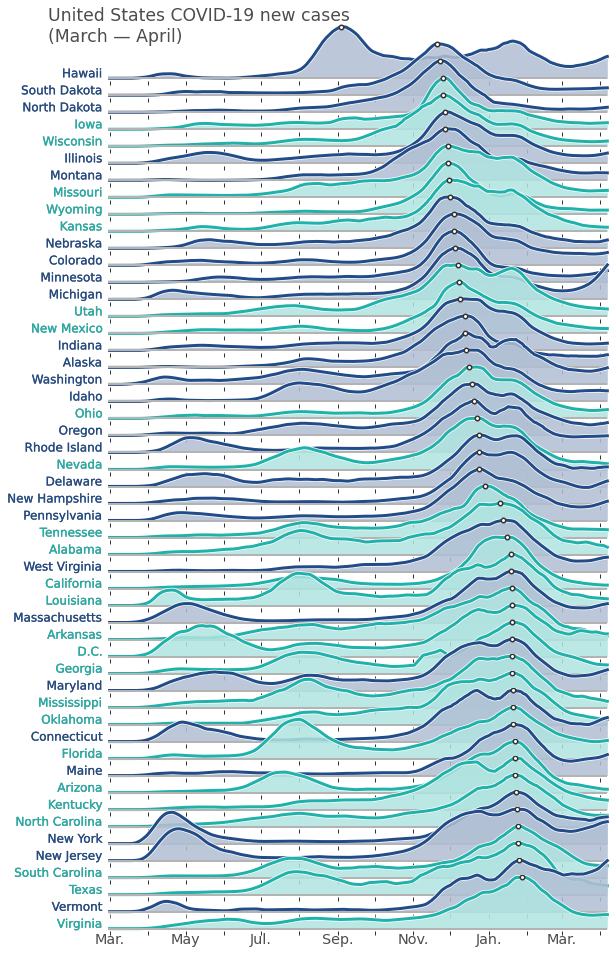

In [15]:
lw = 3
min_c = 10
xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','','Mar.','']

days_since = 14
from matplotlib import gridspec
nrows = 51
cols = plt.cm.gnuplot_r(np.linspace(0.1,0.9,nrows))
scatter_col = '.2'

np.random.shuffle(cols)
gs = gridspec.GridSpec(nrows+1, 1)
fig = plt.figure(figsize=(9, 17))

i = 1

ax_objs = []
for tup in range(1,nrows+1):
    st = ordered_states[tup-1]
    stlab = st

    ll_st = ll.loc[(ll['state']==st)].copy()
    temp = dict(zip(ll_st['date'],ll_st['new_cases']))
    padx = date_dict[ll_st['date'].values[0]]-date_dict['2020-01-21']
    xvals = [date_dict[i] for i in temp.keys()]
    yvals_st = np.nan_to_num(ll_st['new_cases'].rolling(window=wid).mean().values)
    if list(temp.keys())[0]>'2020-01-21':
        xvals = [0]*padx + list(xvals)
        yvals_st = [0]*padx + list(yvals_st)
    else:
        xvals = np.array(xvals)

    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana Islands'

    ymax_i = np.argmax(yvals_st)
    ymax = yvals_st[ymax_i]
    ax_objs[-1].plot(xvals, yvals_st, color=col_co, linewidth=lw,
                     path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                                   path_effects.Normal()])
    ax_objs[-1].scatter([ymax_i-1+date_dict['2020-01-21']], [ymax], c='w',
                        lw=lw/2, edgecolors=scatter_col,zorder=4, s=20)
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color='w', alpha=0.8,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color=col_co, alpha=0.3,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].hlines(0, date_dict['2020-02-28'], xvals[-1], color='.7', alpha=1, lw=2, zorder=5)

    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    ax_objs[-1].set_yticks([])
    ax_objs[-1].set_yticklabels([])

    if i == nrows-1:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels([i for i in xtxl],fontsize='x-large')
        ax_objs[-1].tick_params(axis="x", pad=15, colors='.3')

    else:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels(['' for i in xtx])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.01,0.01,stlab,transform=ax_objs[-1].transAxes,
                     fontsize='large',va='bottom',ha="right",color=col_co,alpha=0.99,
                     path_effects=[path_effects.Stroke(linewidth=0.2, foreground='.2'),
                                   path_effects.Normal()])
    ax_objs[-1].set_xlim(date_dict['2020-02-28'],xvals[-1]+2)

    i += 1

gs.update(hspace=-0.7)

fig.text(0.0325,0.88,'United States COVID-19 new cases\n(March — %s)'%month_dict[today.split('-')[1]],
               color='.3', fontsize='xx-large', va='top', ha='left')

plt.savefig('../figs/pngs/ridgeplot_cases.png', dpi=300, bbox_inches='tight')
plt.show()

# Ridge plot of cases per 1,000

In [16]:
regions_dict = {'Plains':['Iowa', 'Kansas', 'Minnesota', 'Missouri',
                          'Nebraska', 'North Dakota', 'South Dakota'],
                'Rocky Mountains':['Colorado', 'Idaho', 'Montana', 'Utah', 'Wyoming'],
                'Far West':['Alaska', 'California', 'Hawaii', 'Nevada', 'Oregon', 'Washington'],
                'Southwest':['Arizona', 'New Mexico', 'Oklahoma', 'Texas'],
                'Great Lakes':['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin'],
                'Southeast':['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Kentucky', 'Louisiana',
                             'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee',
                             'Virginia', 'West Virginia'],
                'New England':['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
                               'Rhode Island', 'Vermont'],
                'Mid East':['Delaware', 'District of Columbia', 'Maryland', 'New Jersey',
                            'New York', 'Pennsylvania']}

reg_names = [[list(regions_dict.keys())[i]]*len(list(regions_dict.values())[i]) for i in range(len(regions_dict))]
reg_state = list(regions_dict.values())

flat_names = [item for sublist in reg_names for item in sublist]
flat_state = [item for sublist in reg_state for item in sublist]
region_df = pd.DataFrame({'region':flat_names,'state':flat_state})

In [17]:
ll = ll.merge(region_df, how='left', on='state')
ll.loc[ll.region.isna(),'region'] = 'other'

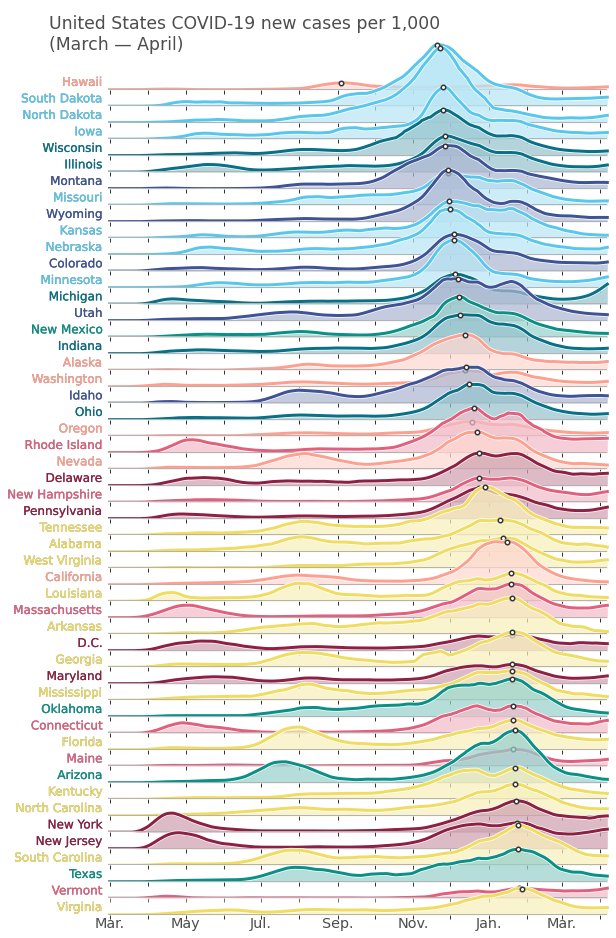

In [18]:
lw = 3
min_c = 10
xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','','Mar.','']


days_since = 14
from matplotlib import gridspec
cols = ['#EFDC60','#FEA090','#0A9086','#3E5496','#E0607E','#8E2043','#077187','#59C7EB']
# cols = ["#6f9c45","#9750a1","#4bc490","#b94a73","#b67837","#ba4c41","#c0a83b","#6778d0"]
cols = dict(zip(ll.region.unique()[1:],cols))
cols['other'] = '.5'
scatter_col = '.2'

gs = gridspec.GridSpec(nrows+1, 1)
fig = plt.figure(figsize=(9, 17))

i = 1

ax_objs = []
for tup in range(1,nrows+1):
    st = ordered_states[tup-1]
    stlab = st

    ll_st = ll.loc[(ll['state']==st)].copy().drop_duplicates()
    temp = dict(zip(ll_st['date'],ll_st['new_cases_per_1000']))
    padx = date_dict[ll_st['date'].values[0]]-date_dict['2020-01-21']
    xvals = [date_dict[i] for i in temp.keys()]
    yvals_st = np.nan_to_num(ll_st['new_cases_per_1000'].rolling(window=wid).mean().values)
    if list(temp.keys())[0]>'2020-01-21':
        xvals = [0]*padx + list(xvals)
        yvals_st = [0]*padx + list(yvals_st)
    else:
        xvals = np.array(xvals)

    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana Islands'

    ymax_i = np.argmax(yvals_st)
    ymax = yvals_st[ymax_i]
    col_co = cols[ll_st['region'].unique()[0]]
    ax_objs[-1].plot(xvals, yvals_st, color=col_co, linewidth=lw,
                     path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                                   path_effects.Normal()])
    ax_objs[-1].scatter([ymax_i-1+date_dict['2020-01-21']], [ymax], c='w',
                        lw=lw/2, edgecolors=scatter_col,zorder=4, s=20)
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color='w', alpha=0.6,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color=col_co, alpha=0.3,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].hlines(0, date_dict['2020-02-28'], xvals[-1], color='.7', alpha=1, lw=2, zorder=5)

    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    ax_objs[-1].set_yticks([])
    ax_objs[-1].set_yticklabels([])

    if i == nrows-1:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels([i for i in xtxl],fontsize='x-large')
        ax_objs[-1].tick_params(axis="x", pad=15, colors='.3')

    else:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels(['' for i in xtx])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.01,0.01,stlab,transform=ax_objs[-1].transAxes,
                     fontsize='large',va='bottom',ha="right",color=col_co,alpha=0.99,
                     path_effects=[path_effects.Stroke(linewidth=0.2, foreground='.2'),
                                   path_effects.Normal()])
    ax_objs[-1].set_xlim(date_dict['2020-02-28'],xvals[-1]+2)
    ax_objs[-1].set_ylim(0,2.0)

    i += 1

gs.update(hspace=-0.8)

fig.text(0.035,0.86,'United States COVID-19 new cases per 1,000\n(March — %s)'%month_dict[today.split('-')[1]],
               color='.3', fontsize='xx-large', va='top', ha='left')

plt.savefig('../figs/pngs/ridgeplot_cases_per_1000.png', dpi=300, bbox_inches='tight')
plt.show()

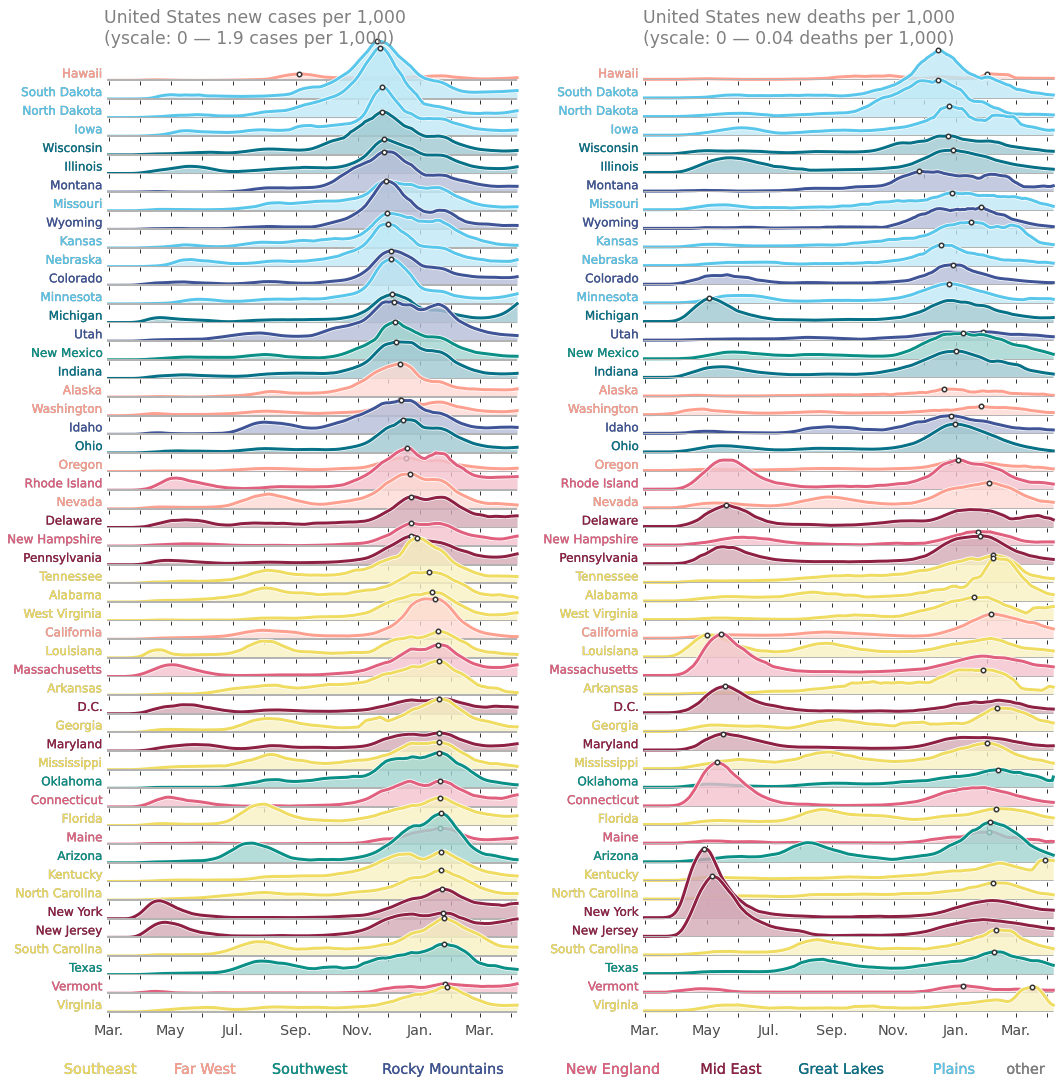

In [19]:
min_c = 10
xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','','Mar.','']

dates = ll.date.unique().tolist()
date_dict = dict(zip(dates, list(range(len(dates)))))

days_since = 14
from matplotlib import gridspec
nrows = 51
cols = plt.cm.tab20b(np.linspace(0,1,ll.region.nunique()+3))
cols = ['#EFDC60','#FEA090','#0A9086','#3E5496','#E0607E','#8E2043','#077187','#59C7EB']
# cols = ["#6f9c45","#9750a1","#4bc490","#b94a73","#b67837","#ba4c41","#c0a83b","#6778d0"]
cols = dict(zip(ll.region.unique()[1:],cols))
cols['other'] = '.5'
gs = gridspec.GridSpec(nrows+1, 2)
fig = plt.figure(figsize=(17, 18.85))

i = 1

ax_objs1 = []
ax_objs2 = []
for tup in range(1,nrows+1):
    st = ordered_states[tup-1]
    stlab = st

    ll_st = ll.loc[(ll['state']==st)].copy()
    temp = dict(zip(ll_st['date'],ll_st['new_cases']))
    padx = date_dict[ll_st['date'].values[0]]-date_dict['2020-01-22']
    xvals = [date_dict[i] for i in temp.keys()]
    yvals_st = np.nan_to_num(ll_st['new_cases'].rolling(window=14).mean().values)
    yvals_st = np.nan_to_num(ll_st['new_cases_per_1000'].rolling(window=wid).mean().values)

    if list(temp.keys())[0]>'2020-01-21':
        xvals = [0]*padx + list(xvals)
        yvals_st = [0]*padx + list(yvals_st)
    else:
        xvals = np.array(xvals)

    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana Islands'
    ax_objs1.append(fig.add_subplot(gs[i:i+1, 0]))
    ax_objs2.append(fig.add_subplot(gs[i:i+1, 1]))
    
    ymax_i = np.argmax(yvals_st)
    ymax = yvals_st[ymax_i]
    col_co = cols[ll_st['region'].unique()[0]]

    ax_objs1[-1].plot(xvals, yvals_st, color=col_co, linewidth=lw,
                      path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                                    path_effects.Normal()])
    ax_objs1[-1].scatter([ymax_i-1+date_dict['2020-01-22']], [ymax], c='w',
                         lw=lw/2, edgecolors=scatter_col,zorder=4, s=20)
    ax_objs1[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color='w', alpha=0.7,
                             linewidth=0.1, edgecolors='w')
    ax_objs1[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color=col_co, alpha=0.3,
                             linewidth=0.1, edgecolors='w')
    ax_objs1[-1].hlines(0, date_dict['2020-02-28'], xvals[-1], color='.7', alpha=1, lw=2, zorder=5)

    ll_st = ll.loc[(ll['state']==st)].copy()
    temp = dict(zip(ll_st['date'],ll_st['new_deaths']))
    padx = date_dict[ll_st['date'].values[0]]-date_dict['2020-01-22']
    xvals = [date_dict[i] for i in temp.keys()]
    yvals_st = np.nan_to_num(ll_st['new_deaths_per_1000'].rolling(window=wid+7).mean().values)

    if list(temp.keys())[0]>'2020-01-21':
        xvals = [0]*padx + list(xvals)
        yvals_st = [0]*padx + list(yvals_st)
    else:
        xvals = np.array(xvals)

    ymax_i = np.argmax(yvals_st)
    ymax = yvals_st[ymax_i]
    ax_objs2[-1].plot(xvals, yvals_st, color=col_co, linewidth=lw,
                      path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                                    path_effects.Normal()])
    ax_objs2[-1].scatter([ymax_i-1+date_dict['2020-01-22']], [ymax], c='w',
                         lw=lw/2, edgecolors=scatter_col,zorder=4, s=20)
    ax_objs2[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color='w', alpha=0.7,
                             linewidth=0.1, edgecolors='w')
    ax_objs2[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color=col_co, alpha=0.3,
                             linewidth=0.1, edgecolors='w')
    ax_objs2[-1].hlines(0, date_dict['2020-02-28'], xvals[-1], color='.7', alpha=1, lw=1, zorder=5)

    rect = ax_objs1[-1].patch
    rect.set_alpha(0)
    rect = ax_objs2[-1].patch
    rect.set_alpha(0)

    ax_objs1[-1].set_yticks([])
    ax_objs1[-1].set_yticklabels([])
    ax_objs2[-1].set_yticks([])
    ax_objs2[-1].set_yticklabels([])

    if i == nrows-1:
        ax_objs1[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs1[-1].set_xticklabels([i for i in xtxl],fontsize='x-large')
        ax_objs1[-1].tick_params(axis="x", pad=25.5, colors='.3')
        ax_objs2[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs2[-1].set_xticklabels([i for i in xtxl],fontsize='x-large')
        ax_objs2[-1].tick_params(axis="x", pad=25.5, colors='.3')
        
    else:
        ax_objs1[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs1[-1].set_xticklabels(['' for i in xtx])
        ax_objs2[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs2[-1].set_xticklabels(['' for i in xtx])

    ax_objs1[-1].spines['bottom'].set_color('.8')
    ax_objs2[-1].spines['bottom'].set_color('.8')
    spines = ["top","right","left",'bottom']
    for s in spines:
        ax_objs1[-1].spines[s].set_visible(False)
        ax_objs2[-1].spines[s].set_visible(False)

    ax_objs1[-1].text(-0.01,0.01,stlab,transform=ax_objs1[-1].transAxes,
                     fontsize='large',va='bottom',ha="right",color=col_co,alpha=0.99,
                     path_effects=[path_effects.Stroke(linewidth=0.2, foreground='.2'),
                                   path_effects.Normal()])
    ax_objs2[-1].text(-0.01,0.01,stlab,transform=ax_objs2[-1].transAxes,
                     fontsize='large',va='bottom',ha="right",color=col_co,alpha=0.99,
                     path_effects=[path_effects.Stroke(linewidth=0.2, foreground='.2'),
                                   path_effects.Normal()])

    ax_objs1[-1].set_xlim(date_dict['2020-02-28'],xvals[-1]+2)
    ax_objs2[-1].set_xlim(date_dict['2020-02-28'],xvals[-1]+2)

    ax_objs1[-1].set_ylim(-0.020,1.90)
    ax_objs2[-1].set_ylim(-0.001,0.04)

    i += 1

gs.update(hspace=-0.75,wspace=0.3)

fig.text(0.123,0.865,'United States new cases per 1,000\n'+\
         '(yscale: 0 — 1.9 cases per 1,000)',
               color='.5', fontsize='xx-large', va='top', ha='left')
fig.text(0.563,0.865,'United States new deaths per 1,000\n'+\
         '(yscale: 0 — 0.04 deaths per 1,000)',
               color='.5', fontsize='xx-large', va='top', ha='left')

ix = 0.09
for lab, c in cols.items():
    fig.text(ix, 0.08, lab, color=c, fontsize='x-large',
             path_effects=[path_effects.Stroke(linewidth=0.2, foreground='.2'),
                                   path_effects.Normal()])
    ix += 0.01*len(lab)

plt.savefig('../figs/pngs/ridgeplot_cases_both.png', dpi=300, bbox_inches='tight')

plt.show()

# Ridge plot of cases all on the same scale

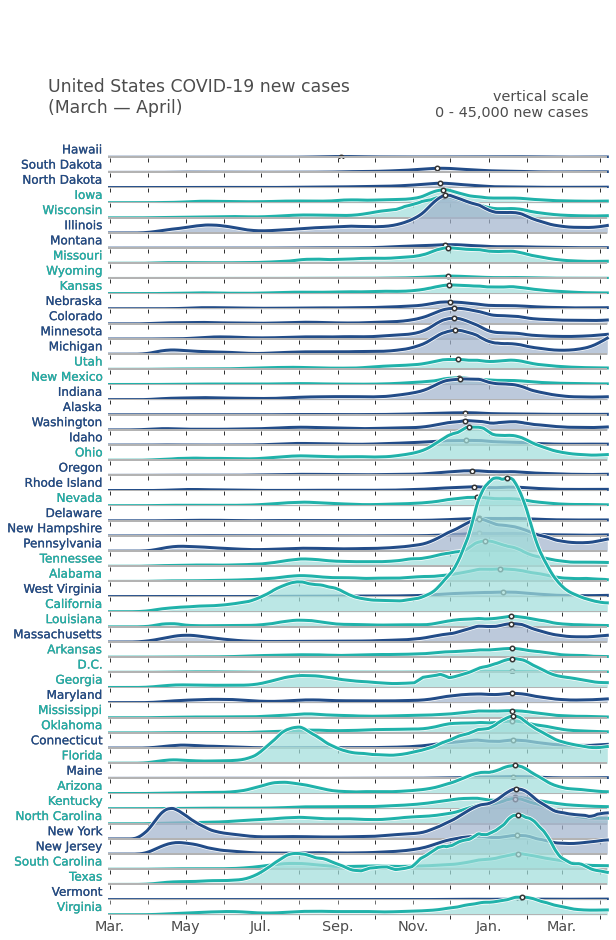

In [20]:
min_c = 10
xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','','Mar.','']


days_since = 14
from matplotlib import gridspec

gs = gridspec.GridSpec(nrows+1, 1)
fig = plt.figure(figsize=(9, 17))
scatter_col = '.2'

i = 1

ax_objs = []
for tup in range(1,nrows+1):
    st = ordered_states[tup-1]
    stlab = st

    ll_st = ll.loc[(ll['state']==st)].copy()
    temp = dict(zip(ll_st['date'],ll_st['new_cases']))
    padx = date_dict[ll_st['date'].values[0]]-date_dict['2020-01-22']
    xvals = [date_dict[i] for i in temp.keys()]
    yvals_st = np.nan_to_num(ll_st['new_cases'].rolling(window=wid).mean().values)
    if list(temp.keys())[0]>'2020-01-21':
        xvals = [0]*padx + list(xvals)
        yvals_st = [0]*padx + list(yvals_st)
    else:
        xvals = np.array(xvals)

    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana Islands'
    
    ymax_i = np.argmax(yvals_st)
    ymax = yvals_st[ymax_i]
    ax_objs[-1].plot(xvals, yvals_st, color=col_co, linewidth=lw,
                     path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                                   path_effects.Normal()])
    ax_objs[-1].scatter([ymax_i-1+date_dict['2020-01-22']], [ymax], c='w',
                        lw=lw/2, edgecolors=scatter_col,zorder=4, s=20)
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color='w', alpha=0.6,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].fill_between(xvals, yvals_st, [0]*len(xvals), color=col_co, alpha=0.3,
                             linewidth=0.1, edgecolors='w')
    ax_objs[-1].hlines(0, date_dict['2020-02-28'], xvals[-1], color='.7', alpha=1, lw=2, zorder=5)

    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    ax_objs[-1].set_yticks([])
    ax_objs[-1].set_yticklabels([])

    if i == nrows-1:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels([i for i in xtxl],fontsize='x-large')
        ax_objs[-1].tick_params(axis="x", pad=15, colors='.3')
        
    else:
        ax_objs[-1].set_xticks([date_dict[i] for i in xtx])
        ax_objs[-1].set_xticklabels(['' for i in xtx])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.01,0.01,stlab,transform=ax_objs[-1].transAxes,
                     fontsize='large',va='bottom',ha="right",color=col_co,alpha=0.99,
                     path_effects=[path_effects.Stroke(linewidth=0.2, foreground='.2'),
                                   path_effects.Normal()])
    ax_objs[-1].set_xlim(date_dict['2020-02-28'],xvals[-1]+2)
    ax_objs[-1].set_ylim(-200,45000)
    ax_objs[-1].spines['bottom'].set_color('.5')
    ax_objs[-1].spines['bottom'].set_color('.5')

    i += 1

gs.update(hspace=-0.9)

fig.text(0.0325,0.81,'United States COVID-19 new cases\n(March — %s)'%month_dict[today.split('-')[1]],
               color='.3', fontsize='xx-large', va='top', ha='left')
fig.text(0.8675,0.80,'vertical scale\n0 - 45,000 new cases',
               color='.3', fontsize='x-large', va='top', ha='right')

plt.savefig('../figs/pngs/ridgeplot_cases_samescale.png', dpi=300, bbox_inches='tight')
plt.show()

___________

# Correlations

In [21]:
from scipy.stats import linregress

In [22]:
# Define function for string formatting of scientific notation
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)


In [23]:
state_posx_lim = state_posx.copy()
# del state_posx_lim['gu']
# del state_posx_lim['pr']
# del state_posx_lim['vi']
# del state_posx_lim['mp']

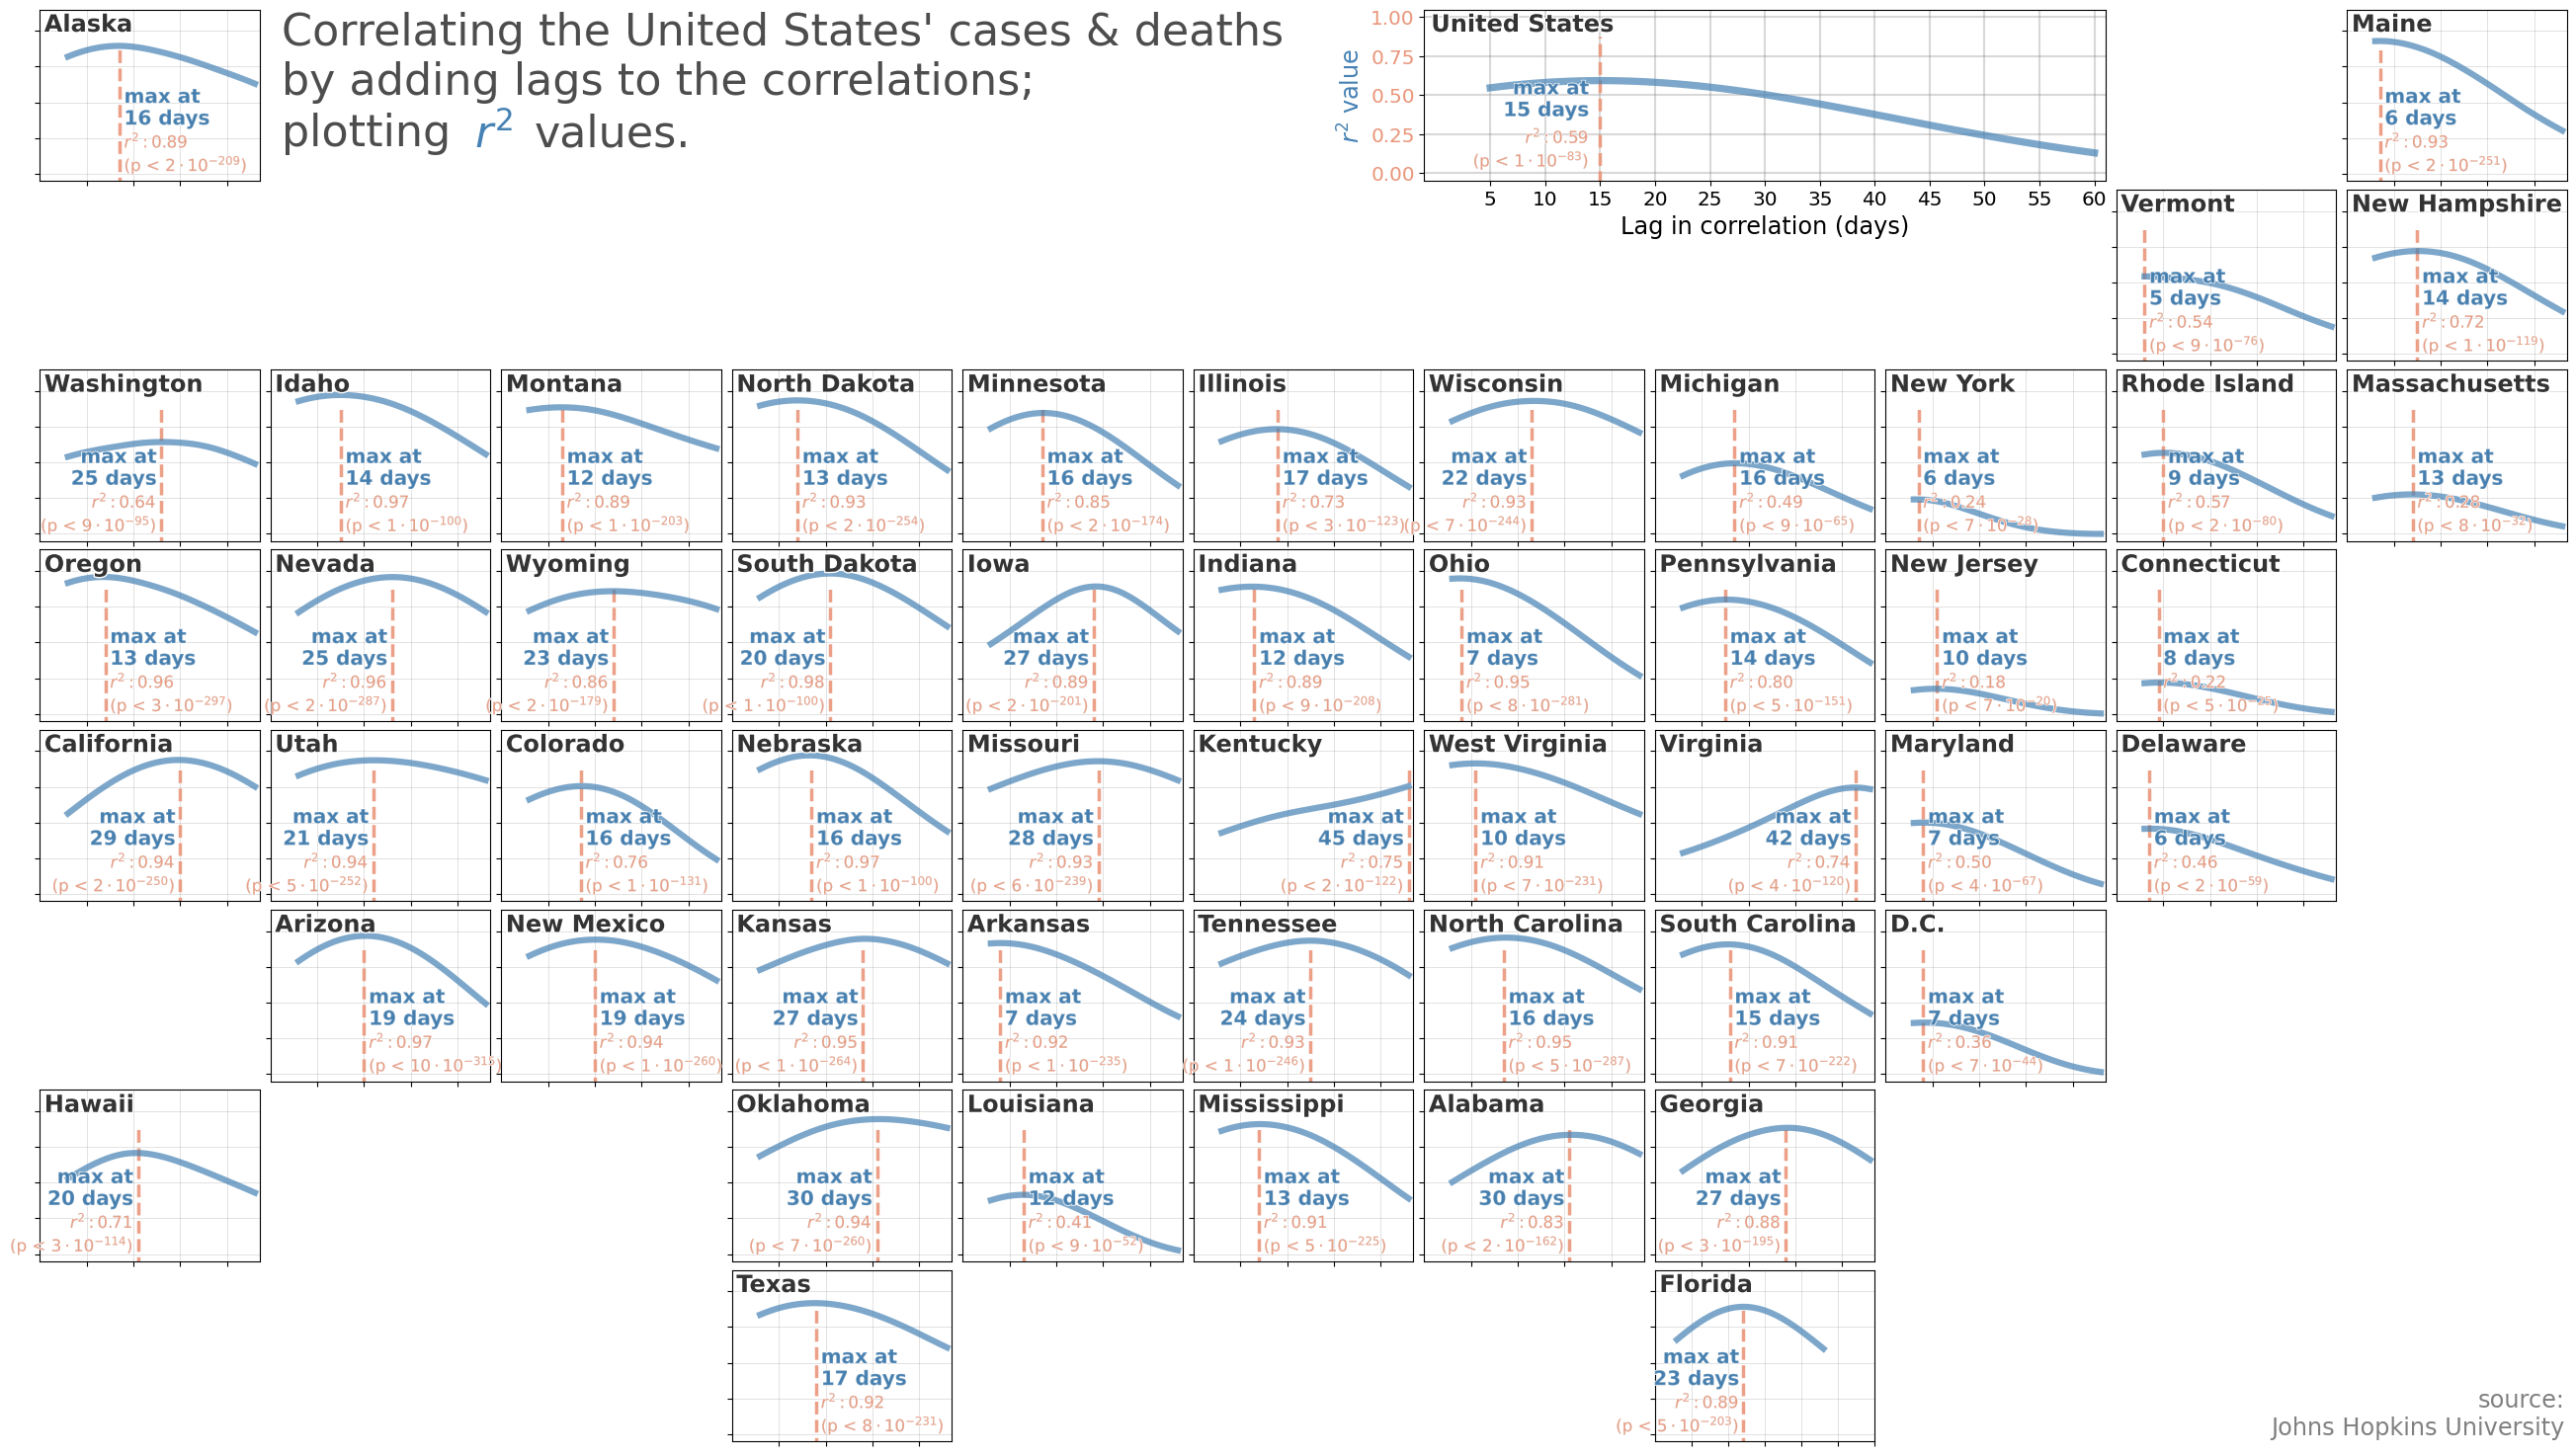

In [24]:
w = 3.0
h = 2.4
ncols = 11
nrows = 8
tups = list(it.product(range(nrows), range(ncols)))

col_co = '.2'
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

test_st = {}

for st, po in state_posx_lim.items():
    stlab = all_state_names[st]
    ll_st = ll.loc[(ll['state']==stlab)].copy()
    
    delays = list(range(5,61))
    r_delays = {}
    p_delays = {}
    for d in delays[:-15]:
        xcases = np.nan_to_num(ll_st['new_cases'].rolling(window=wid).mean().values)[:-d]
        ydeaths = np.nan_to_num(ll_st['new_deaths'].rolling(window=wid).mean().values)[d:]
        sl_d, int_d, rva_d, pva_d, _ = linregress(xcases,ydeaths)
        r_delays[d] = rva_d**2
        p_delays[d] = pva_d

    xvals_st = list(r_delays.keys())
    yvals_st_r = list(r_delays.values())

    ax[po].plot(xvals_st, yvals_st_r, color='steelblue', linewidth=lw*1.5, alpha=0.7)
    ax[po].vlines(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))], -1, 0.875,
                  linestyle='--', color='darksalmon', linewidth=2.5, alpha=0.9)
    test_st[stlab] = np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]
    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color=col_co,fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])

    x1 = np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]+1
    lr1 = 'left' if x1 < xvals_st[-1]*0.45 else 'right'
    if lr1 == 'right':
        x1 -= 2
    p_text = p_delays[max(r_delays, key=r_delays.get)]
    if p_delays[max(r_delays, key=r_delays.get)] == 0:
        p_text = 1e-100

    ax[po].text(x1, 0.6, 'max at\n%i days'%max(r_delays, key=r_delays.get),
           fontsize='x-large',va='top',ha=lr1, color='.2', fontweight='bold',
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])
    ax[po].text(x1, 0.6, 'max at\n%i days'%max(r_delays, key=r_delays.get),
           fontsize='x-large',va='top',ha=lr1, color='steelblue', alpha=0.8, fontweight='bold',
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])
    ax[po].text(x1, 0.3, r'$r^2: %.2f$'%max(list(r_delays.values()))+\
           '\n(p < %s)'%sci_notation(p_text,decimal_digits=0),
           fontsize='large',va='top',ha=lr1, color='.2',
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])
    ax[po].text(x1, 0.3, r'$r^2: %.2f$'%max(list(r_delays.values()))+\
           '\n(p < %s)'%sci_notation(p_text,decimal_digits=0),
           fontsize='large',va='top',ha=lr1, color='darksalmon', alpha=0.8,
                path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),
                              path_effects.Normal()])

    ax[po].set_ylim(-0.05, 1.15)
    ax[po].set_xlim(np.nonzero(np.nan_to_num(yvals_st_r))[0][0]-1,xvals_st[-1]+1)
    xtx = delays[4::10]
    ytx = [0.0,0.25,0.5,0.75,1.0]
    ax[po].set_xticks(xtx)
    ax[po].set_xticklabels(['' for i in xtx])
    ax[po].set_yticks(ytx)
    ax[po].set_yticklabels(['' for i in ytx])   
    ax[po].grid(linewidth=0.5,color='.2',alpha=0.2)

    
for tup in tups:
    if tup not in state_posx_lim.values():
        ax[tup].set_axis_off()

ax[tups[-1]].text(0.99,0.01,'source:\nJohns Hopkins University',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.05,0.99,
   "Correlating the United States' cases & deaths\nby adding lags to the correlations;\n",
               color='.3', fontsize=32, va='top', ha='left', transform=ax[(0,1)].transAxes)
ax[(0,1)].text(0.05,0.4, "plotting", color='.3', fontsize=32,
               va='top', ha='left', transform=ax[(0,1)].transAxes)
ax[(0,1)].text(0.925,0.4, r"$r^2$", color='steelblue', fontsize=32,
               va='top', ha='left', transform=ax[(0,1)].transAxes)
ax[(0,1)].text(1.2,0.4, "values.", color='.3', fontsize=32,
               va='top', ha='left', transform=ax[(0,1)].transAxes)

usa_tots = ll.groupby(['date']).agg({'new_cases':np.nansum,'new_deaths':np.nansum,
                                     'population':'sum'}).reset_index()

r_delays = {}
p_delays = {}
for d in delays:
    xcases = np.nan_to_num(usa_tots['new_cases'].rolling(window=wid).mean().values)[:-d]
    ydeaths = np.nan_to_num(usa_tots['new_deaths'].rolling(window=wid).mean().values)[d:]
    sl_d, int_d, rva_d, pva_d, _ = linregress(xcases, ydeaths)
    r_delays[d] = rva_d**2
    p_delays[d] = pva_d

xvals_st = list(r_delays.keys())
yvals_st_r = list(r_delays.values())

gs = ax[1, 8].get_gridspec()
for a in ax[0:1, 6:9].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:1, 6:9])

stlab = 'United States'
axbig.plot(xvals_st, yvals_st_r, color='steelblue', linewidth=lw*1.75, alpha=0.7)
axbig.vlines(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))], -1, 0.875,
              linestyle='--', color='darksalmon', linewidth=2.5, alpha=0.9)
test_st[stlab] = np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]

axbig.text(0.01,0.98,stlab,fontsize='xx-large',va='top',ha='left',
           color=col_co,fontweight='bold',transform=axbig.transAxes,
           path_effects=[path_effects.Stroke(linewidth=2, foreground='w'), path_effects.Normal()])

ydiff = np.nanmax(yvals_st_r)-np.nanmin(yvals_st_r)
axbig.text(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]-1, 0.6,
           'max at\n%i days'%np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))],
           fontsize='x-large',va='top',ha='right', color='.2', fontweight='bold',
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'), path_effects.Normal()])
axbig.text(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]-1, 0.6,
           'max at\n%i days'%np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))],
           fontsize='x-large',va='top',ha='right', color='steelblue', alpha=0.8, fontweight='bold',
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'),  path_effects.Normal()])
axbig.text(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]-1, 0.3,
           r'$r^2: %.2f$'%np.nanmax(yvals_st_r)+\
           '\n(p < %s)'%sci_notation(p_delays[np.argmax(np.nan_to_num(yvals_st_r))],decimal_digits=0),
           fontsize='large',va='top',ha='right', color='.2',
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'), path_effects.Normal()])
axbig.text(np.array(xvals_st)[np.argmax(np.nan_to_num(yvals_st_r))]-1, 0.3,
           r'$r^2: %.2f$'%np.nanmax(yvals_st_r)+\
           '\n(p < %s)'%sci_notation(p_delays[np.argmax(np.nan_to_num(yvals_st_r))],decimal_digits=0),
           fontsize='large',va='top',ha='right', color='darksalmon', alpha=0.8,
           path_effects=[path_effects.Stroke(linewidth=0.9, foreground='w'), path_effects.Normal()])

axbig.set_ylim(-0.05, 1.05)

xtx = delays[0::5]
axbig.set_xticks(xtx)
axbig.set_xticklabels(xtx,fontsize='x-large')
axbig.set_yticks([0.0,0.25,0.5,0.75,1.0])
axbig.set_yticklabels(["%.2f"%i for i in [0.0,0.25,0.5,0.75,1.0]],fontsize='x-large')
axbig.set_ylabel(r"$r^2$ value",fontsize='xx-large', color='steelblue')
axbig.set_xlabel("Lag in correlation (days)",fontsize='xx-large')
axbig.tick_params(axis='y', labelcolor='darksalmon')

axbig.grid(linewidth=1.5,color='.5',alpha=0.3)
axbig.set_xlim(np.nonzero(np.nan_to_num(yvals_st_r))[0][0]-1,xvals_st[-1]+1)

plt.savefig('../figs/pngs/state_subplot_correlations_casedeath.png', dpi=300, bbox_inches='tight')
plt.show()

# Misc

In [25]:
from scipy.stats import entropy

stlab = 'United States'
usa_tots = ll.loc[ll['state']==stlab]
xvals_usa = np.array([date_dict[i] for i in sorted(usa_tots['date'].tolist())])
yvals_usa = np.nan_to_num(usa_tots['new_cases'].rolling(window=7).mean().values)
usa_dict = dict(zip(xvals_usa,yvals_usa/np.nansum(yvals_usa)))

ent_dict = {}
for st, po in state_posx.items():
    if st in ['gu','vi','mp','hi']:
        continue
    stlab = all_state_names[st]
    ll_st = ll.loc[ll['state']==stlab].copy()

    xvals_st = np.array([date_dict[i] for i in sorted(ll_st['date'].tolist())])
    yvals_st = np.nan_to_num(np.array(ll_st['new_cases'].rolling(window=7).mean().values))
    yvals_st[yvals_st<0] = 0
    st_dict = dict(zip(xvals_st, yvals_st))
    sta_dict = {i:st_dict[i]/np.nansum(yvals_st) if i in list(st_dict.keys()) else 0 for i in usa_dict.keys()}
    
    usa_vals = np.array(list(usa_dict.values()))
    sta_vals = np.array(list(sta_dict.values()))
    
    ent_dict[stlab] = entropy(sta_vals, usa_vals)
    
ent_dict = dict(sorted(ent_dict.items(), key=lambda x: x[1], reverse=True))

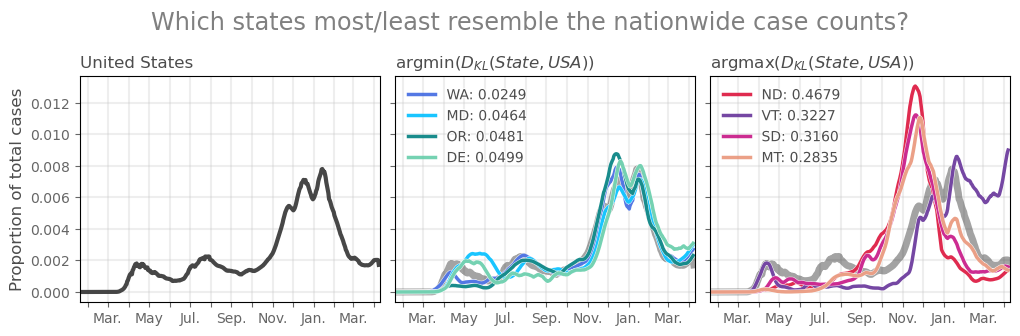

In [26]:
all_names_state = {j:i.upper() for i,j in all_state_names.items()}
n = 4

xtx = ['2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
       '2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01']
xtxl = ['','Mar.','','May','','Jul.','','Sep.','','Nov.','','Jan.','','Mar.','']


fig,ax = plt.subplots(1,3,figsize=(12,3),dpi=100,sharey=True,sharex=True)
ax[0].plot(list(usa_dict.keys()), list(usa_dict.values()), linewidth=3, alpha=0.9, color='.2')

colset1 = ['royalblue','deepskyblue','teal','mediumaquamarine']
sim_states = list(ent_dict.keys())[-n:]
ax[1].plot(list(usa_dict.keys()), list(usa_dict.values()), linewidth=5, alpha=0.4, color='.1')
for si,stlab in enumerate(sim_states[::-1]):
    ll_st = ll.loc[ll['state']==stlab].copy()
    xvals_st = np.array([date_dict[i] for i in sorted(ll_st['date'].tolist())])
    yvals_st = np.nan_to_num(np.array(ll_st['new_cases'].rolling(window=14).mean().values))
    yvals_st[yvals_st<0] = 0
    st_dict = dict(zip(xvals_st, yvals_st))
    sta_dict = {i:st_dict[i]/np.nansum(yvals_st) if i in list(st_dict.keys()) else 0 for i in usa_dict.keys()}
    ax[1].plot(list(sta_dict.keys())[:-1], list(sta_dict.values())[:-1], linewidth=3.2, alpha=0.9,color='w')
    ax[1].plot(list(sta_dict.keys())[:-1], list(sta_dict.values())[:-1], linewidth=2.5, alpha=0.9,color=colset1[si],
               label="%s: %.4f"%(all_names_state[stlab], ent_dict[stlab]))

colset2 = ['crimson','rebeccapurple','mediumvioletred','darksalmon']
sim_states = list(ent_dict.keys())[:n]
ax[2].plot(list(usa_dict.keys()), list(usa_dict.values()), linewidth=5, alpha=0.4, color='.1')
for si,stlab in enumerate(sim_states):
    ll_st = ll.loc[ll['state']==stlab].copy()
    xvals_st = np.array([date_dict[i] for i in sorted(ll_st['date'].tolist())])
    yvals_st = np.nan_to_num(np.array(ll_st['new_cases'].rolling(window=14).mean().values))
    yvals_st[yvals_st<0] = 0
    st_dict = dict(zip(xvals_st, yvals_st))
    sta_dict = {i:st_dict[i]/np.nansum(yvals_st) if i in list(st_dict.keys()) else 0 for i in usa_dict.keys()}
    ax[2].plot(list(sta_dict.keys())[:-1], list(sta_dict.values())[:-1], linewidth=3.2, alpha=0.9,color='w')
    ax[2].plot(list(sta_dict.keys())[:-1], list(sta_dict.values())[:-1], linewidth=2.5, alpha=0.9,color=colset2[si],
               label="%s: %.4f"%(all_names_state[stlab], ent_dict[stlab]))
    

l = ax[1].legend(loc=2,ncol=1,framealpha=0,fontsize='medium')
for text in l.get_texts():
    text.set_color(".3")
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

l = ax[2].legend(loc=2,ncol=1,framealpha=0,fontsize='medium')
for text in l.get_texts():
    text.set_color(".3")
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

ax[0].set_ylabel('Proportion of total cases',color='.3',fontsize='large')
ax[0].set_title('United States',x=0,ha='left',color='.3')
ax[1].set_title(r'argmin($D_{KL}(State, USA)$)',x=0,ha='left',color='.3')
ax[2].set_title(r'argmax($D_{KL}(State, USA)$)',x=0,ha='left',color='.3')

plt.subplots_adjust(wspace=0.05)
for a in fig.axes:
    a.set_xlim(-2,list(sta_dict.keys())[-1]+2)
    a.set_xticks([date_dict[i] for i in xtx])
    a.set_xticklabels(xtxl)
    a.grid(color='.75',alpha=0.25,linewidth=1.5)
    a.tick_params(labelcolor='.4',color='.4')

plt.suptitle('Which states most/least resemble the nationwide case counts?',
             y=1.1, fontsize='xx-large',color='.5')

plt.savefig('../figs/pngs/dkl_state_usa.png',dpi=425,bbox_inches='tight')
plt.show()

In [ ]:
month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}


In [ ]:
# url_x = 'https://healthdata.gov/resource/anag-cw7u.json'
# with urllib.request.urlopen(url_x) as url_i:
#     data_i = json.loads(url_i.read().decode())

# hosp = pd.DataFrame(data_i)
# hosp['fips_code'] = hosp['fips_code'].astype(str)
# hosp['zip'] = hosp['zip'].astype(str)
# hospx = hosp[['collection_week','state','hospital_name',
#               'city','zip','fips_code']].copy()

# hospx['collection_week'] = hosp.date.astype(str).str[:4] + '-' +\
#                hosp.date.astype(str).str[4:6] + '-' + hosp.date.astype(str).str[-2:]


https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u

In [ ]:
hosp_fn = 'https://healthdata.gov/api/views/anag-cw7u/rows.csv?accessType=DOWNLOAD'
hosp = pd.read_csv(hosp_fn, dtype={'fips_code':str,'zip':str})
hosp['collection_week'] = hosp.collection_week.astype(str).str[0:4] + '-' +\
                          hosp.collection_week.astype(str).str[5:7] + '-' +\
                          hosp.collection_week.astype(str).str[-2:]
# hosp = hosp.loc[hosp['state']=='NY'].copy()
hospx = hospy[['collection_week','state','hospital_name',
              'city','zip','fips_code']].copy()
print(hospx['collection_week'].max())

In [ ]:
nrep = 100

In [ ]:
child_avg = []
child_col1 = 'previous_day_admission_pediatric_covid_confirmed_7_day_sum'
child_col2 = 'previous_day_admission_pediatric_covid_suspected_7_day_sum'
hosp[child_col1] = hosp[child_col1].astype(float)
hosp[child_col2] = hosp[child_col2].astype(float)
age_i = '00-17_7_day_sum'
for i in range(nrep):
    if i % 100 == 0:
        print(age_i,i)
    tmp1 = [i if i != -999999.0 else np.random.randint(1,5) for i in hosp[child_col1]]
    tmp2 = [i if i != -999999.0 else np.random.randint(1,5) for i in hosp[child_col2]]
#     tmp1 = [i if i != -999999.0 else np.random.randint(1,2) for i in hosp[child_col1]]
#     tmp2 = [i if i != -999999.0 else np.random.randint(1,2) for i in hosp[child_col2]]
    tmp = np.array(tmp1) + np.array(tmp2)
    child_avg.append(tmp)

hospx['hosp_'+age_i] = np.nan_to_num(np.mean(child_avg,axis=0))

In [ ]:
age_columns = ['18-19_7_day_sum','20-29_7_day_sum','30-39_7_day_sum','40-49_7_day_sum',
               '50-59_7_day_sum','60-69_7_day_sum','70-79_7_day_sum','80+_7_day_sum']

col1 = 'previous_day_admission_adult_covid_confirmed_'
col2 = 'previous_day_admission_adult_covid_suspected_'

for age_i in age_columns:
    col1_a = col1 + age_i
    col2_a = col2 + age_i
    hosp[col1_a] = hosp[col1_a].astype(float)
    hosp[col2_a] = hosp[col2_a].astype(float)
    age_avg = []
    for i in range(nrep):
        if i % 100 == 0:
            print(age_i,i)
        tmp1 = [i if i != -999999.0 else np.random.randint(1,5) for i in hosp[col1_a]]
        tmp2 = [i if i != -999999.0 else np.random.randint(1,5) for i in hosp[col2_a]]
        tmp = np.array(tmp1) + np.array(tmp2)
        age_avg.append(tmp)

    hospx['hosp_'+age_i] = np.nan_to_num(np.mean(age_avg,axis=0))

In [ ]:
col1 = 'previous_day_admission_adult_covid_confirmed_7_day_sum'
col2 = 'previous_day_admission_adult_covid_suspected_7_day_sum'
col3 = 'previous_day_admission_pediatric_covid_confirmed_7_day_sum'
col4 = 'previous_day_admission_pediatric_covid_suspected_7_day_sum'
hosp[col1] = hosp[col1].astype(float)
hosp[col2] = hosp[col2].astype(float)
hosp[col3] = hosp[col3].astype(float)
hosp[col4] = hosp[col4].astype(float)
age_i = 'all_ages_7_day_sum'
tot_avg = []
for i in range(nrep):
    if i % 100 == 0:
        print(age_i,i)
    tmp1 = [i if i != -999999.0 else np.random.randint(1,5) for i in hosp[col1]]
    tmp2 = [i if i != -999999.0 else np.random.randint(1,5) for i in hosp[col2]]
    tmp3 = [i if i != -999999.0 else np.random.randint(1,5) for i in hosp[col3]]
    tmp4 = [i if i != -999999.0 else np.random.randint(1,5) for i in hosp[col4]]
#     tmp1 = [i if i != -999999.0 else np.random.randint(1,2) for i in hosp[col1]]
#     tmp2 = [i if i != -999999.0 else np.random.randint(1,2) for i in hosp[col2]]
#     tmp3 = [i if i != -999999.0 else np.random.randint(1,2) for i in hosp[col3]]
#     tmp4 = [i if i != -999999.0 else np.random.randint(1,2) for i in hosp[col4]]
    tmp = np.array(tmp1) + np.array(tmp2) + np.array(tmp3) + np.array(tmp4)
    tot_avg.append(tmp)

hospx['hosp_'+age_i] = np.nan_to_num(np.mean(tot_avg,axis=0))

In [ ]:
agcols = ['00-17_7_day_sum','18-19_7_day_sum','20-29_7_day_sum',
          '30-39_7_day_sum','40-49_7_day_sum','50-59_7_day_sum',
          '60-69_7_day_sum','70-79_7_day_sum','80+_7_day_sum']
hospx['hosp_all_ages_7_day_sum'] = hospx[['hosp_'+i for i in agcols]].sum(axis=1)
agcols = ['00-17_7_day_sum','18-19_7_day_sum','20-29_7_day_sum',
          '30-39_7_day_sum','40-49_7_day_sum','50-59_7_day_sum',
          '60-69_7_day_sum','70-79_7_day_sum','80+_7_day_sum','all_ages_7_day_sum']
agcols = ['hosp_'+i for i in agcols]

In [ ]:
# hospx.to_csv('../data/massachusetts_hosp_age_facility.csv', index=False)
# hospx.to_csv('../data/massachusetts_hosp_age_statewide.csv', index=False)

In [ ]:
hospxg = hospx.groupby('collection_week').agg({i:'sum' for i in agcols}).reset_index()

In [ ]:
# hospxg.to_csv('../data/ny_hosp_age_statewide.csv', index=False)

In [ ]:
# hospxg.to_csv('../data/massachusetts_hosp_age_statewide.csv', index=False)

In [ ]:
for a in agcols[:-1]:
    hospxg['frac_'+a] = hospxg[a] / hospxg[agcols[-1]]

In [ ]:
hospxg['frac_hosp_00-19_7_day_sum'] = sum([hospxg['frac_'+a] for a in agcols[0:2]])
hospxg['under_50'] = sum([hospxg['frac_'+a] for a in agcols[0:5]])
hospxg['50_to_70'] = sum([hospxg['frac_'+a] for a in agcols[5:7]])
hospxg['above_70'] = sum([hospxg['frac_'+a] for a in agcols[7:9]])

hospxg['under_60'] = sum([hospxg['frac_'+a] for a in agcols[0:6]])
hospxg['above_60'] = sum([hospxg['frac_'+a] for a in agcols[6:9]])

In [ ]:
import matplotlib.ticker as mtick

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,3.5),dpi=200)
plt.subplots_adjust(wspace=0.35)
lw = 3
young_cols = list(plt.cm.Blues_r(np.linspace(0.1, 0.7, 4)))
older_cols = list(plt.cm.Reds(np.linspace(0.3, 0.9, 4)))
colors = young_cols + older_cols
# colors = plt.cm.coolwarm(np.linspace(0,1,2))
plotcols = ['00-19_7_day_sum','20-29_7_day_sum','30-39_7_day_sum','40-49_7_day_sum',
            '50-59_7_day_sum','60-69_7_day_sum','70-79_7_day_sum','80+_7_day_sum']
wid = 1
for ai, a in enumerate(plotcols):
    ax[0].plot([date_dict[i]+6 for i in hospxg['collection_week']],
             hospxg['frac_hosp_'+a].rolling(window=wid).mean().values,
             color=colors[ai], lw=lw, alpha=0.9, label=a.replace("_7_day_sum",""))

colors = plt.cm.coolwarm(np.linspace(0,1,2))
for ai, a in enumerate(['under_60','above_60']):
    ax[1].plot([date_dict[i]+6 for i in hospxg['collection_week']],
             hospxg[a].rolling(window=wid).mean().values,
             color=colors[ai], lw=lw, alpha=0.9, label=a.replace("_"," "))

dates = [i for i in date_dict.keys() if i > '2020-09-26'][7::21]
rr = 0
ax[0].set_ylim(0.02, 0.26)
for a in fig.axes:
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates], fontsize='small')
#     a.set_xlim(date_dict['2020-11-24'],date_dict[hospxg['collection_week'].max()]+1)
    a.set_xlim(date_dict['2020-11-24'],date_dict[hospxg['collection_week'].max()]+7)

    if rr == 0:
        l = a.legend(loc='upper left', bbox_to_anchor=(0, -0.16),
                 ncol=4, fontsize='x-small', framealpha=0)
    else:
        l = a.legend(loc='upper left', bbox_to_anchor=(0, -0.16),
                     fontsize='x-small', framealpha=0)

    for text in l.get_texts():
        text.set_color('.4')
    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
    rr += 1
    
ax[0].set_title('Percentage of hospitalizations\n(confirmed & suspected COVID-19)',
                x=0,color='.3',ha='left',fontsize='medium')
ax[1].set_title('Percentage of hospitalizations\n(confirmed & suspected COVID-19)',
                x=0,color='.3',ha='left',fontsize='medium')

ax[-1].text(0.975,-0.19,'source:\nHealthData.gov',color='.5',fontsize='small',
                va='top', ha='right', transform=ax[-1].transAxes)

# plt.savefig('../figs/pngs/ma_fraction_of_hospitalizations_by_age.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pngs/fraction_of_hospitalizations_by_age.png',dpi=425,bbox_inches='tight')
plt.show()

In [ ]:
hospxg['under_50'] = sum([hospxg['frac_'+a] for a in agcols[0:5]])
hospxg['50_to_70'] = sum([hospxg['frac_'+a] for a in agcols[5:7]])
hospxg['above_70'] = sum([hospxg['frac_'+a] for a in agcols[7:9]])

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,3.5),dpi=200)
plt.subplots_adjust(wspace=0.35)
lw = 3
young_cols = list(plt.cm.Blues_r(np.linspace(0.1, 0.7, 4)))
older_cols = list(plt.cm.Reds(np.linspace(0.3, 0.9, 4)))
colors = young_cols + older_cols
# colors = plt.cm.coolwarm(np.linspace(0,1,2))
plotcols = ['00-19_7_day_sum','20-29_7_day_sum','30-39_7_day_sum','40-49_7_day_sum',
            '50-59_7_day_sum','60-69_7_day_sum','70-79_7_day_sum','80+_7_day_sum']
wid = 1
for ai, a in enumerate(plotcols):
    ax[0].plot([date_dict[i]+6 for i in hospxg['collection_week']],
             hospxg['frac_hosp_'+a].rolling(window=wid+1).mean().values,
             color=colors[ai], lw=lw, alpha=0.9, label=a.replace("_7_day_sum",""))

colors = ['cornflowerblue','.5','crimson']
for ai, a in enumerate(['under_50','50_to_70','above_70']):
    ax[1].plot([date_dict[i]+6 for i in hospxg['collection_week']],
             hospxg[a].rolling(window=wid).mean().values,
             color=colors[ai], lw=lw, alpha=0.9, label=a.replace("_"," "))

dates = [i for i in date_dict.keys() if i > '2020-09-26'][7::21]
rr = 0
for a in fig.axes:
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates], fontsize='small')
    a.set_xlim(date_dict['2020-11-24'],date_dict[hospxg['collection_week'].max()]+7)

    if rr == 0:
        l = a.legend(loc='upper left', bbox_to_anchor=(0, -0.16),
                     ncol=4, fontsize='x-small', framealpha=0)
        a.set_ylim(0.01, 0.26)
    else:
        l = a.legend(loc='upper left', bbox_to_anchor=(0, -0.16),
                     ncol=2, fontsize='x-small', framealpha=0)
        a.set_ylim(0.21, 0.46)

    for text in l.get_texts():
        text.set_color('.4')
    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
    rr += 1
    
ax[0].set_title('Percentage of hospitalizations\n(confirmed & suspected COVID-19)',
                x=0,color='.3',ha='left',fontsize='medium')
ax[1].set_title('Percentage of hospitalizations\n(confirmed & suspected COVID-19)',
                x=0,color='.3',ha='left',fontsize='medium')

ax[-1].text(0.975,-0.19,'source:\nHealthData.gov',color='.5',fontsize='small',
                va='top', ha='right', transform=ax[-1].transAxes)

# plt.savefig('../figs/pngs/ma_fraction_of_hospitalizations_by_age2.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pngs/fraction_of_hospitalizations_by_age2.png',dpi=425,bbox_inches='tight')
plt.show()

In [ ]:
hosp_out = hospxg[['collection_week',
 'hosp_00-17_7_day_sum',
 'hosp_18-19_7_day_sum',
 'hosp_20-29_7_day_sum',
 'hosp_30-39_7_day_sum',
 'hosp_40-49_7_day_sum',
 'hosp_50-59_7_day_sum',
 'hosp_60-69_7_day_sum',
 'hosp_70-79_7_day_sum',
 'hosp_80+_7_day_sum',
 'hosp_all_ages_7_day_sum']].copy()
for i in ['hosp_00-17_7_day_sum', 'hosp_18-19_7_day_sum',
          'hosp_20-29_7_day_sum', 'hosp_30-39_7_day_sum', 'hosp_40-49_7_day_sum',
          'hosp_50-59_7_day_sum', 'hosp_60-69_7_day_sum', 'hosp_70-79_7_day_sum',
          'hosp_80+_7_day_sum', 'hosp_all_ages_7_day_sum']:
    hosp_out[i] = hosp_out[i].astype(int)

In [ ]:
hosp_out.to_csv('../data/hospital_ages_new.csv', index=False)

In [ ]:
adult_col = 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'
child_col = 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'

In [ ]:
# for st in sorted(hosp['state'].unique()):
#     fig, ax = plt.subplots(1,2,figsize=(9,3),dpi=100)
#     adult_avg = []
#     child_avg = []
#     wid = 2

#     for xi in range(500):
#         ma_hosp = hosp.loc[hosp['state']==st].copy()
#         ma_hosp[adult_col] = [i if i != -999999.0 else np.random.randint(1,4) for i in ma_hosp[adult_col]]
#         ma_hosp[child_col] = [i if i != -999999.0 else np.random.randint(1,4) for i in ma_hosp[child_col]]

#         ma_hosp_g = ma_hosp.groupby(['collection_week']).agg({adult_col:np.nansum,
#                                                               child_col:np.nansum}).reset_index()
#         dates = [i for i in ma_hosp_g['collection_week'].values if i > '2020-10-01']
#         ax[0].plot([date_dict[i] for i in dates],
#              ma_hosp_g[child_col].rolling(window=wid).mean().values[-len(dates):],
#              color='.5', lw=1, alpha=0.01, marker='')
#         ax[1].plot([date_dict[i] for i in dates],
#              ma_hosp_g[adult_col].rolling(window=wid).mean().values[-len(dates):],
#              color='.7', lw=4, alpha=0.01, marker='')
#         adult_avg.append(ma_hosp_g[adult_col].rolling(window=wid).mean().values[-len(dates):])
#         child_avg.append(ma_hosp_g[child_col].rolling(window=wid).mean().values[-len(dates):])

#     ax[0].plot([date_dict[i] for i in dates], np.mean(child_avg,axis=0),
#          color='indianred', lw=1.5, alpha=0.9,
#                label='pediatric patients (est.\nb/c of reporting noise)',marker='.')
#     ax[1].plot([date_dict[i] for i in dates], np.mean(adult_avg,axis=0),
#          color='indianred', lw=1.5, alpha=0.9,
#                label='adult patients',marker='.')

#     ax[0].set_title('Total pediatric patients hospitalized in %s'%st+\
#                     '\nconfirmed & sustected covid (7-day average)',
#                  x=1,color='.3',ha='right',fontsize='medium')
#     ax[1].set_title('Total adult patients hospitalized in %s'%st+\
#                     '\nconfirmed & sustected covid (7-day average)',
#                  x=1,color='.3',ha='right',fontsize='medium')

#     for a in fig.axes:
#         a.legend(loc=2, fontsize='small')
#         a.set_xticks([date_dict[i] for i in dates[0::2]])
#         a.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in dates[0::2]], fontsize='small')
#         a.set_xlim(date_dict['2020-10-01']-1,
#                    date_dict[ma_hosp_g['collection_week'].values[-1]]+2)
#         a.tick_params(labelcolor='.4', color='.4')
#         a.grid(linewidth=1.25,color='.75',alpha=0.25)

#     plt.savefig('../figs/pngs/state_hosps/pediatric_and_adult_%s.png'%st,dpi=425,bbox_inches='tight')
#     plt.close()

In [ ]:
wid = 2

w = 3.33; h = 2.75
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=200)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.25)

stout = {}
for st, po in list(state_posx.items()):#[11:15]:
    print(st,dt.datetime.now())
    stlab = all_state_names[st]
    child_avg = []

    for xi in range(nrep):
        ma_hosp = hosp.loc[hosp['state']==st.upper()].copy()
        ma_hosp[adult_col] = [i if i != -999999.0 else np.random.randint(1,5) for i in ma_hosp[adult_col]]
        ma_hosp[child_col] = [i if i != -999999.0 else np.random.randint(1,5) for i in ma_hosp[child_col]]
        ma_hosp_g = ma_hosp.groupby(['collection_week']).agg({adult_col:np.nansum,
                                                              child_col:np.nansum}).reset_index()
        dates = [i for i in ma_hosp_g['collection_week'].values if i > '2020-10-01']
        xvals_st = [date_dict[i] for i in dates]
        yvals_st = ma_hosp_g[child_col].rolling(window=wid).mean().values[-len(dates):]
        ax[po].plot(xvals_st,yvals_st,
                    color='.6', lw=1, alpha=0.02, marker='')
        child_avg.append(yvals_st)
    
    ax[po].plot([date_dict[i] for i in dates], np.mean(child_avg,axis=0),
         color='firebrick', lw=lw, alpha=0.9,marker='.')
    stout[st] = list(np.mean(child_avg,axis=0))

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'New Hampshire':
        stlab = 'N. Hampshire'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    text = ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color='.2',fontweight='bold',transform=ax[po].transAxes)
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                           path_effects.Normal()])

    ylim_st = ax[po].get_ylim()
    xlim_st = ax[po].get_xlim()
    ydiff = ylim_st[1]-ylim_st[0]
    ylim_st = (ylim_st[0], np.nanmax(yvals_st)*1.25)
    if np.nanmax(np.mean(child_avg,axis=0)) <= 13:
        ylim_st = (-0.1, 20)
    ax[po].set_ylim(-0.1, ylim_st[1])
    ax[po].set_ylim(ylim_st[0], ylim_st[1])
    
    ax[po].set_xlim(date_dict['2020-10-01']-1,
               date_dict[ma_hosp_g['collection_week'].values[-1]]+2)
    ax[po].tick_params(labelcolor='.4', color='.4')
    ax[po].set_xticks([date_dict[i] for i in dates[1::6]])
    ax[po].set_xticklabels([i[5:] for i in dates[1::6]], fontsize='small')
    ax[po].grid(linewidth=1.25,color='.75',alpha=0.25)

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()


stlab = 'United States'
child_avg = []

gs = ax[1, 8].get_gridspec()
for a in ax[0:2, 5:8].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:2, 5:8])

for xi in range(nrep):
    usa_hosp = hosp.copy()
    usa_hosp[adult_col] = [i if i != -999999.0 else np.random.randint(1,5)
                           for i in usa_hosp[adult_col]]
    usa_hosp[child_col] = [i if i != -999999.0 else np.random.randint(1,5)
                           for i in usa_hosp[child_col]]
    usa_hosp_g = usa_hosp.groupby(['collection_week']).agg({adult_col:np.nansum,
                                            child_col:np.nansum}).reset_index()
    dates = [i for i in usa_hosp_g['collection_week'].values if i > '2020-10-01']
    xvals_st = [date_dict[i] for i in dates]
    yvals_st = usa_hosp_g[child_col].rolling(window=wid).mean().values[-len(dates):]
    axbig.plot(xvals_st,yvals_st, color='.6', lw=2, alpha=0.02, marker='')
    child_avg.append(yvals_st)

axbig.plot([date_dict[i] for i in dates], np.mean(child_avg,axis=0),
     color='firebrick', lw=lw*2, alpha=0.9,marker='o')

text = axbig.text(0.01,0.97,stlab,fontsize='xx-large',va='top',ha='left',
            color='.2',fontweight='bold',transform=axbig.transAxes)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                       path_effects.Normal()])

ylim_st = axbig.get_ylim()
xlim_st = axbig.get_xlim()
ydiff = ylim_st[1]-ylim_st[0]
ylim_st = (ylim_st[0], np.nanmax(np.mean(child_avg,axis=0))*1.05)
# axbig.set_ylim(0, ylim_st[1])
axbig.set_xlim(date_dict['2020-10-01']-1,
               date_dict[usa_hosp_g['collection_week'].values[-1]]+2)
axbig.tick_params(labelcolor='.4', color='.4')
axbig.set_xticks([date_dict[i] for i in dates[1::2]])
axbig.set_xticklabels([i[5:] for i in dates[1::2]], fontsize='medium')
axbig.grid(linewidth=1.25,color='.75',alpha=0.25)

ax[tups[-1]].text(0.99,0.01,'source:\nHealthData.gov',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.01,0.99,"Total pediatric patients hospitalized\n"+\
                         "confirmed & sustected COVID (7-day average)\n"+\
                         "(week of Oct. 2, 2020 — week of %s. %i, 2021)"%(month_dict[dates[-1][5:7]],
                                                                          int(dates[-1][8:])),
               color='.4', fontsize=28, va='top', ha='left', transform=ax[(0,1)].transAxes)

plt.savefig('../figs/pngs/state_subplot_pediatric_casecounts.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
wid = 4

w = 3.33; h = 2.75
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=200)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.25)

for st, po in list(state_posx.items()):#[11:15]:#
    stlab = all_state_names[st]
    if stlab in ['Northern Mariana Islands','Virgin Islands','Guam',
                 'Puerto Rico', 'District of Columbia']:
        ax[po].set_axis_off()
        continue

    print(stlab,dt.datetime.now())
    adult_avg = []
    child_avg = []

    for xi in range(50):
        ma_hosp = hosp.loc[hosp['state']==st.upper()].copy()
        ma_hosp[adult_col] = [i if i != -999999.0 else np.random.randint(1,5)
                              for i in ma_hosp[adult_col]]
        ma_hosp[child_col] = [i if i != -999999.0 else np.random.randint(1,5)
                              for i in ma_hosp[child_col]]

        ma_hosp_g = ma_hosp.groupby(['collection_week']).agg({adult_col:np.nansum,
                                              child_col:np.nansum}).reset_index()
        dates = [i for i in ma_hosp_g['collection_week'].values if i > '2020-10-01']
        adult_avg.append(ma_hosp_g[adult_col].rolling(window=wid).mean().values[-len(dates):])
        child_avg.append(ma_hosp_g[child_col].rolling(window=wid).mean().values[-len(dates):])
    
    ratio_st = np.mean(child_avg,axis=0)/(np.mean(adult_avg,axis=0)+np.mean(child_avg,axis=0))
    ratio_st = pd.Series(ratio_st).rolling(window=wid+1).mean().values
    total_st = pd.Series((np.mean(adult_avg,axis=0)+np.mean(child_avg,axis=0))).rolling(window=wid+1).mean().values
    ax[po].plot([date_dict[i] for i in dates], total_st/np.nanmax(total_st)*0.06,
         color='.1', lw=4, alpha=0.3)
    ax[po].plot([date_dict[i] for i in dates], ratio_st,
         color='cornflowerblue', lw=3, alpha=0.9,marker='o')
#     stout[st] = list(np.mean(child_avg,axis=0))

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'New Hampshire':
        stlab = 'N. Hampshire'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    text = ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color='.2',fontweight='bold',transform=ax[po].transAxes)
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                           path_effects.Normal()])

    ax[po].set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12])
    ax[po].set_yticklabels(["0%","2%","4%","6%","8%","10%","12%"])
    ax[po].set_ylim(0, 0.0925)

    ax[po].set_xticks([date_dict[i] for i in dates[::6]])
    ax[po].set_xticklabels([i[5:] for i in dates[::6]], fontsize='small')
    ax[po].set_xlim(date_dict['2020-10-21']-1,
               date_dict[ma_hosp_g['collection_week'].values[-1]]+4)
    ax[po].tick_params(labelcolor='.4', color='.4')
    ax[po].grid(linewidth=1.25,color='.75',alpha=0.25)

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()


stlab = 'United States'
child_avg = []

gs = ax[1, 8].get_gridspec()
for a in ax[0:2, 5:8].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:2, 5:8])

adult_avg = []
child_avg = []

for xi in range(300):
    usa_hosp = hosp.copy()
    usa_hosp[adult_col] = [i if i != -999999.0 else np.random.randint(1,5) for i in usa_hosp[adult_col]]
    usa_hosp[child_col] = [i if i != -999999.0 else np.random.randint(1,5) for i in usa_hosp[child_col]]
    usa_hosp_g = usa_hosp.groupby(['collection_week']).agg({adult_col:np.nansum,
                                                            child_col:np.nansum}).reset_index()
    dates = [i for i in usa_hosp_g['collection_week'].values if i > '2020-10-01']
    adult_avg.append(usa_hosp_g[adult_col].rolling(window=wid).mean().values[-len(dates):])
    child_avg.append(usa_hosp_g[child_col].rolling(window=wid).mean().values[-len(dates):])

ratio_st = np.mean(child_avg,axis=0)/(np.mean(adult_avg,axis=0)+np.mean(child_avg,axis=0))
ratio_st = pd.Series(ratio_st).rolling(window=wid+1).mean().values
total_st = pd.Series((np.mean(adult_avg,axis=0)+np.mean(child_avg,axis=0))).rolling(window=wid+1).mean().values
axbig.plot([date_dict[i] for i in dates], total_st/np.nanmax(total_st)*0.06,
            color='.1', lw=4, alpha=0.3)
axbig.plot([date_dict[i] for i in dates], ratio_st,
     color='cornflowerblue', lw=5, alpha=0.9,marker='o')

text = axbig.text(0.01,0.97,stlab,fontsize='xx-large',va='top',ha='left',
            color='.2',fontweight='bold',transform=axbig.transAxes)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                       path_effects.Normal()])

axbig.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12])
axbig.set_yticklabels(["0%","2%","4%","6%","8%","10%","12%"])
axbig.set_ylim(0, 0.0725)
axbig.set_xticks([date_dict[i] for i in dates[::2]])
axbig.set_xticklabels([i[5:] for i in dates[::2]], fontsize='medium')
axbig.set_xlim(date_dict['2020-10-21']-1,
               date_dict[usa_hosp_g['collection_week'].values[-1]]+4)
axbig.tick_params(labelcolor='.4', color='.4')
axbig.grid(linewidth=1.25,color='.75',alpha=0.25)

ax[tups[-1]].text(0.99,0.01,'source:\nHealthData.gov',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.01,0.99,"Fraction of total hospitalizations: pediatric\n"+\
                         "confirmed & sustected COVID (7-day average)\n"+\
                         "(week of Oct. 2, 2020 — week of %s. %i, 2021)"%(month_dict[dates[-1][5:7]],
                                                                          int(dates[-1][8:])),
               color='.4', fontsize=28, va='top', ha='left', transform=ax[(0,1)].transAxes)

plt.savefig('../figs/pngs/state_subplot_pediatric_ratio_casecounts.png', dpi=300, bbox_inches='tight')

plt.show()